In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import jams
import tensorly as tl
import librosa
import librosa.display as dp

import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import musicntd.autosimilarity_segmentation as as_seg
from musicntd.model.current_plot import *
import musicntd.scripts.overall_scripts as scr
import nn_fac.ntd as NTD

# Song choice

In [2]:
# Song
persisted_path = "C:\\Users\\amarmore\\Desktop\\data_persisted"

sampling_rate = 44100 # Obligatoire, sinon l'estimation des mesures ne fonctionne pas.
hop_length = 32
hop_length_seconds = hop_length/sampling_rate
subdivision = 96

# RWC Pop
dataset_path = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\Entire RWC"
annotations_type = "MIREX10"
annotations_folder = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\annotations\\{}".format(annotations_type)
song_number = 14
#14, 39, 47
song_path = dataset_path + "\\" + str(song_number) + ".wav"
annotation_path = "{}\\{}".format(annotations_folder, dm.get_annotation_name_from_song(song_number, annotations_type))

# Come Together
song_path = "C:\\Users\\amarmore\\Downloads\\The Beatles - Come Together.wav"
annotation_path = "C:\\Users\\amarmore\\Downloads\\annotations\\ComeTogether.lab"

song_name = song_path.split("\\")[-1].replace(".wav","")

the_signal, original_sampling_rate = sf.read(song_path)
if original_sampling_rate != sampling_rate:
    the_signal = librosa.core.resample(np.asfortranarray(the_signal), original_sampling_rate, sampling_rate)

# Annotations - Homemade
annotations = dm.get_segmentation_from_txt(annotation_path, "MIREX10")
references_segments = np.array(annotations)[:,0:2]

# Get the downbeats
bars = scr.load_or_save_bars(persisted_path, song_path)

# Annotaions in bars
annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)

spectrogram = scr.load_or_save_spectrogram(persisted_path, song_path, "pcp", hop_length, fmin = 98)

tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)

# NTD

## Looping on $Q$

Rank of Q: 2


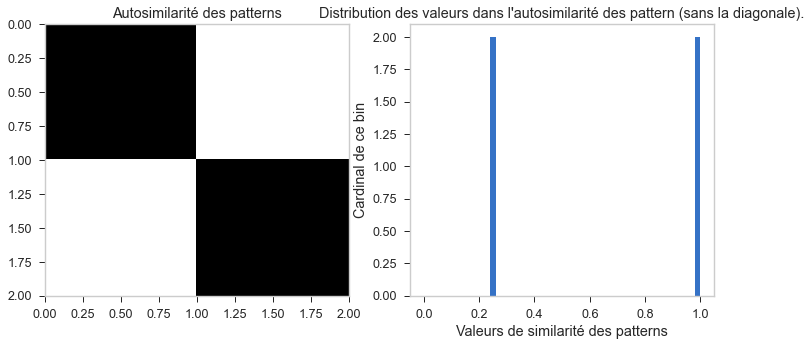

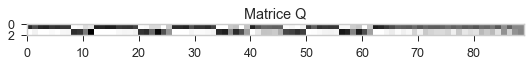

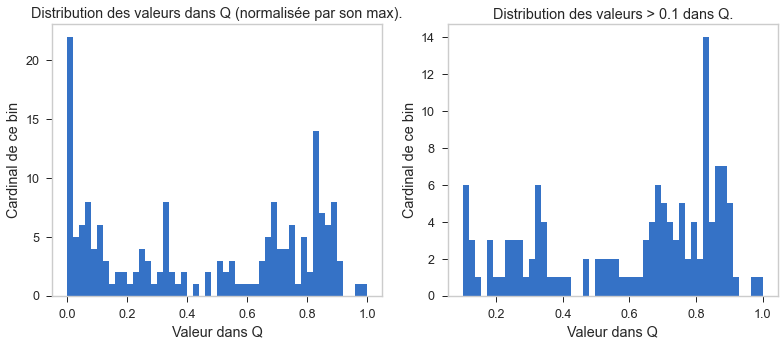

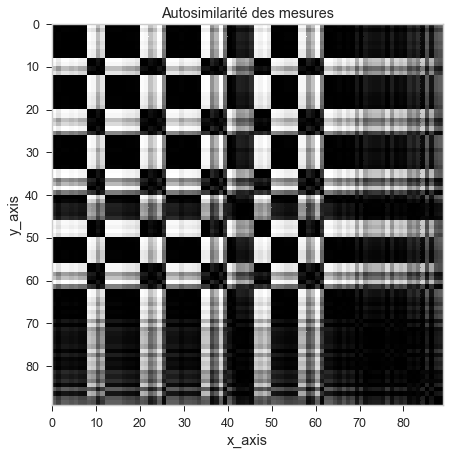

Rank of Q: 3


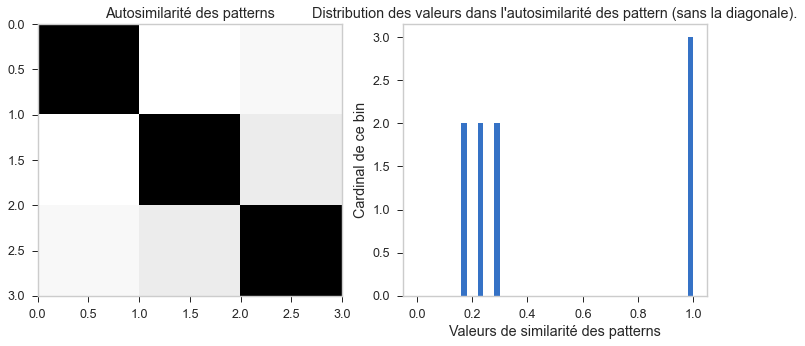

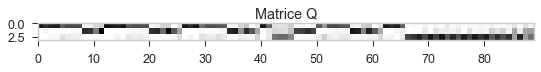

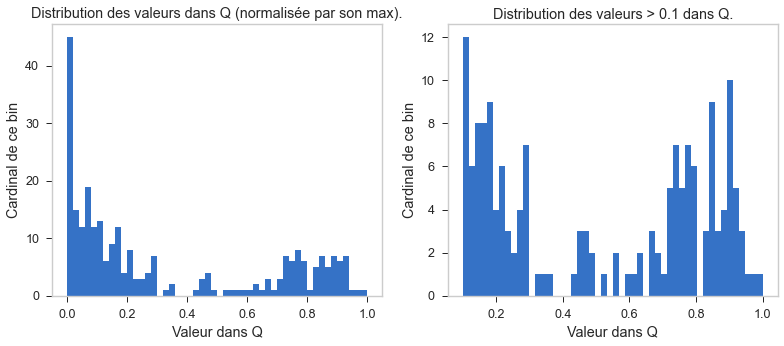

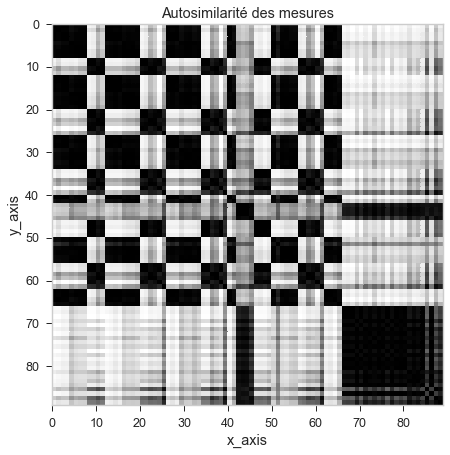

Rank of Q: 4


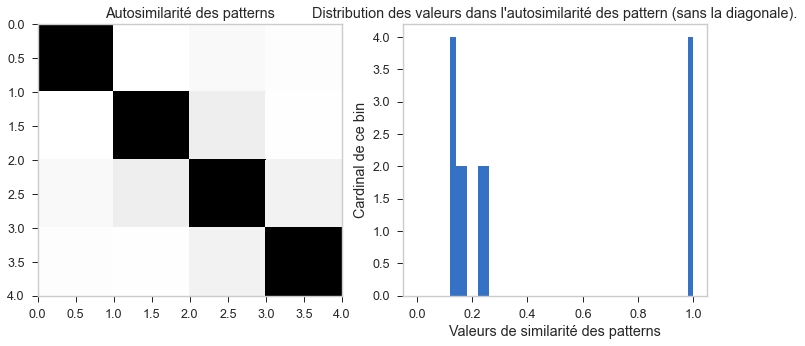

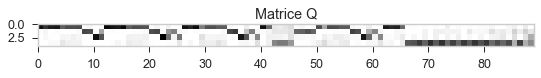

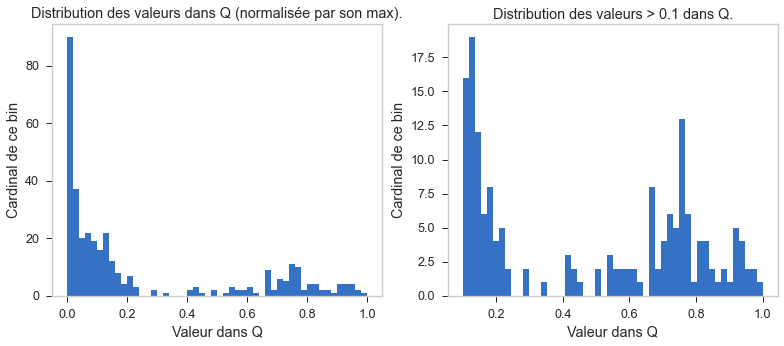

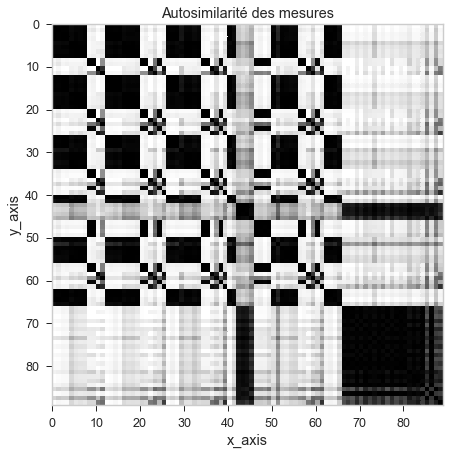

Rank of Q: 5


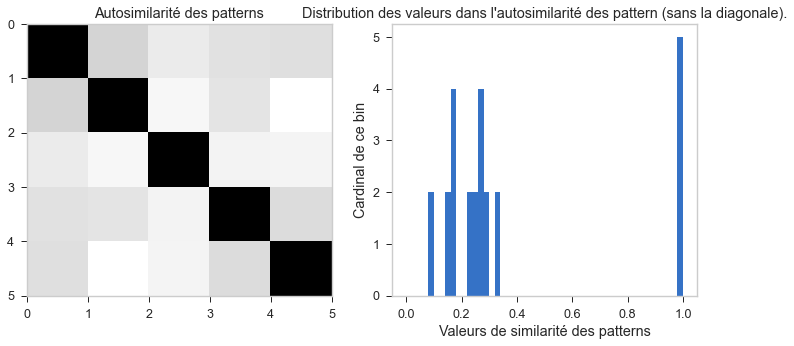

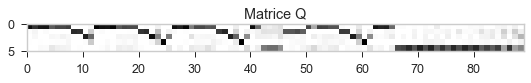

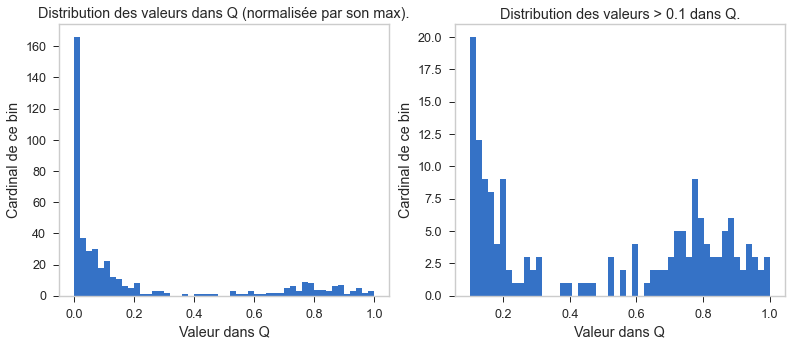

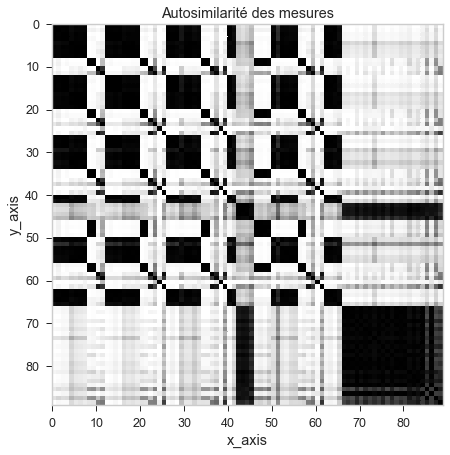

Rank of Q: 6


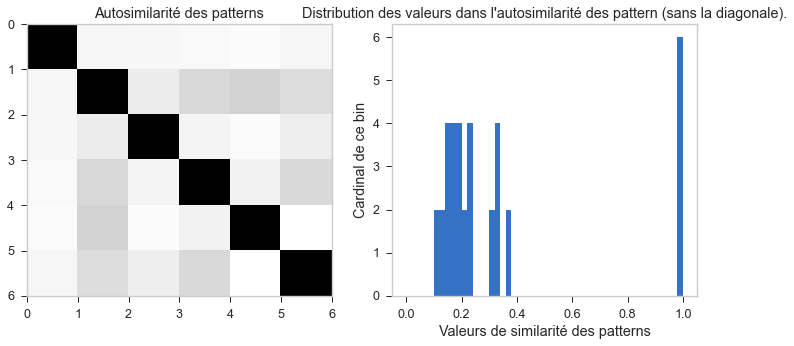

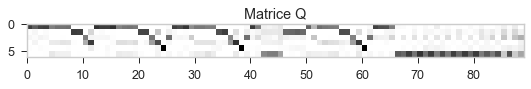

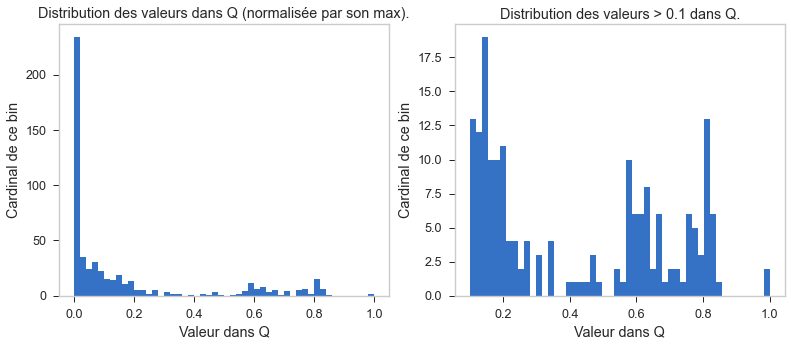

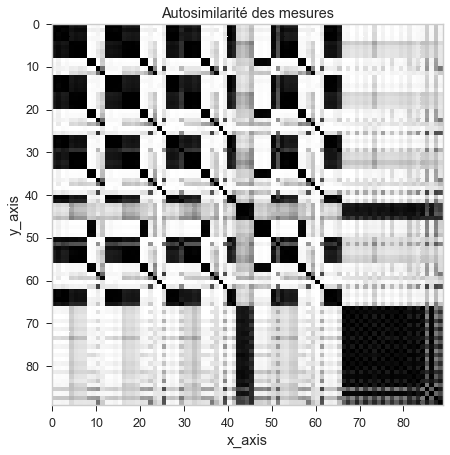

Rank of Q: 7


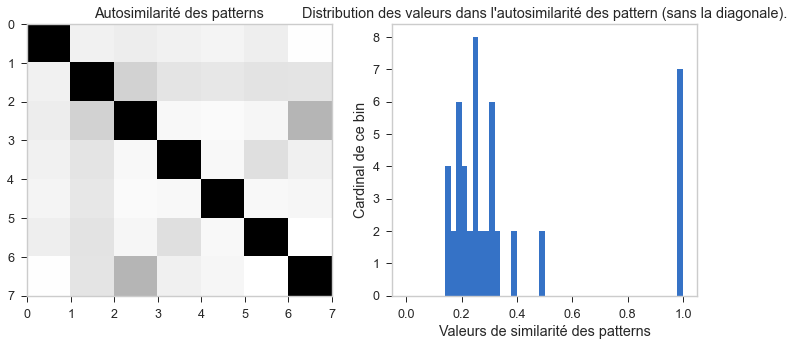

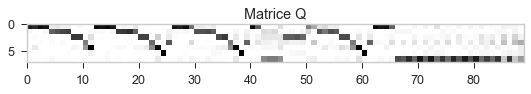

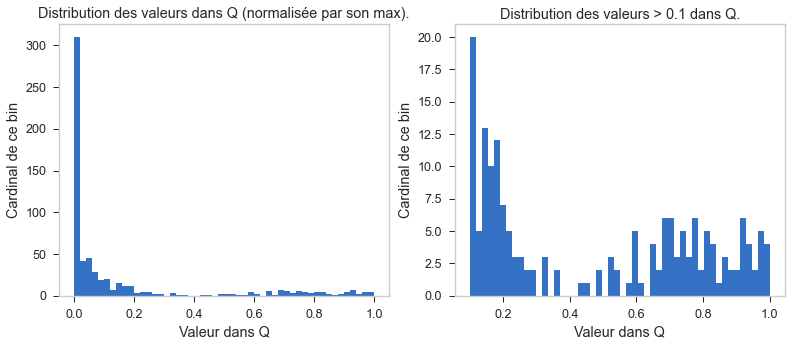

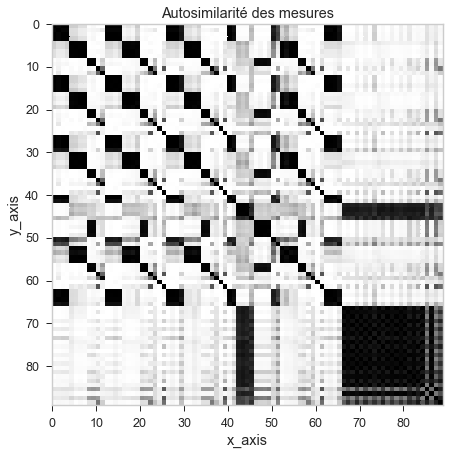

Rank of Q: 8


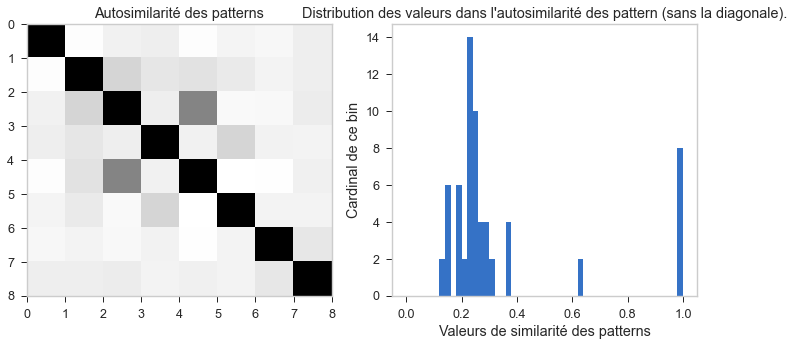

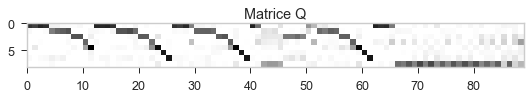

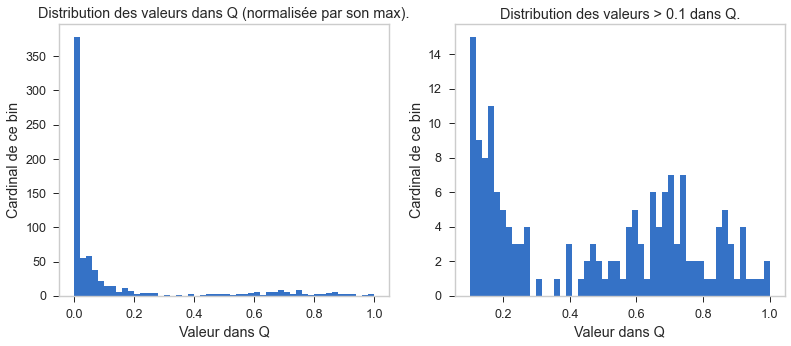

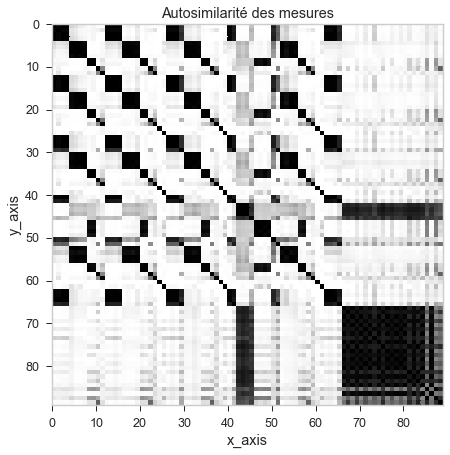

Rank of Q: 9


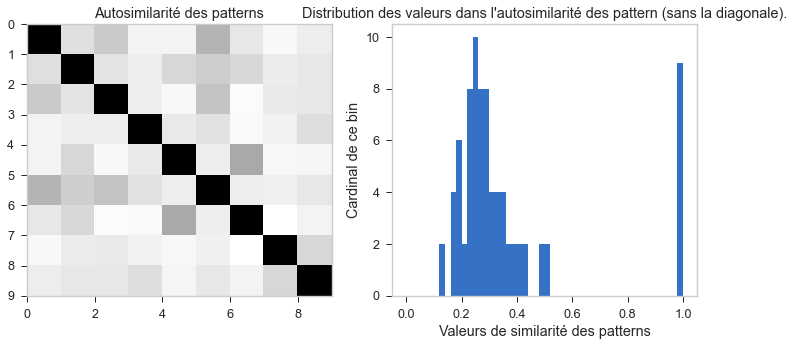

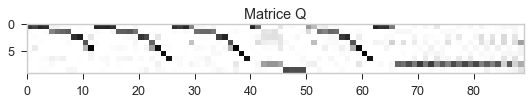

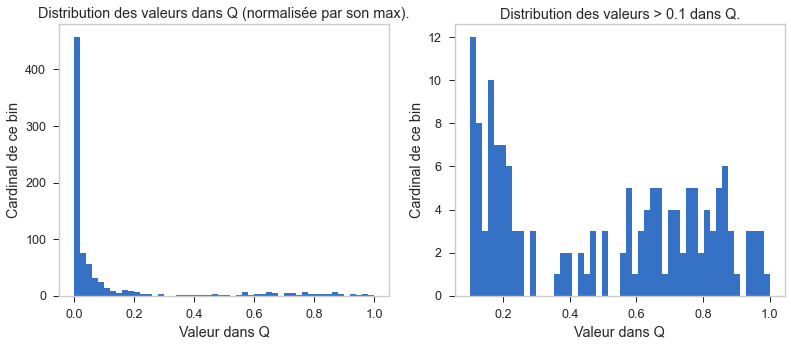

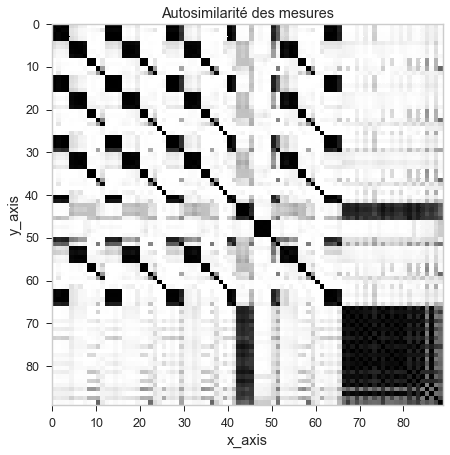

Rank of Q: 10


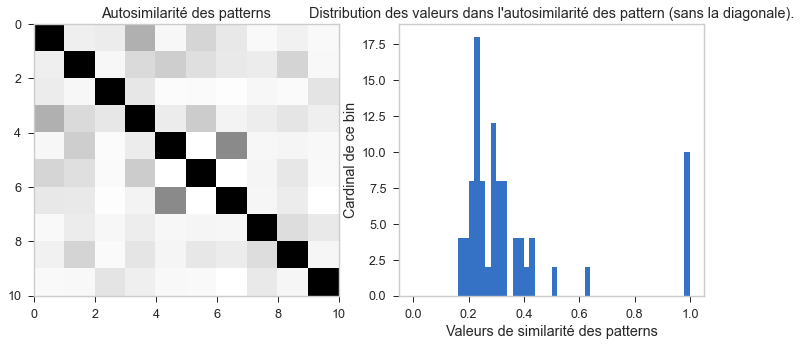

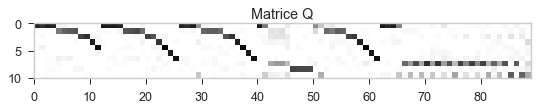

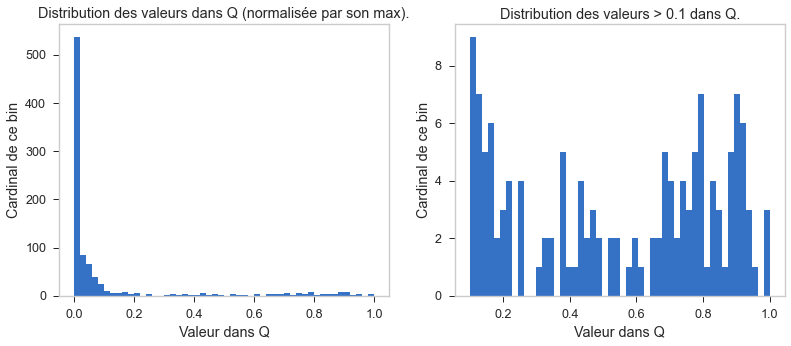

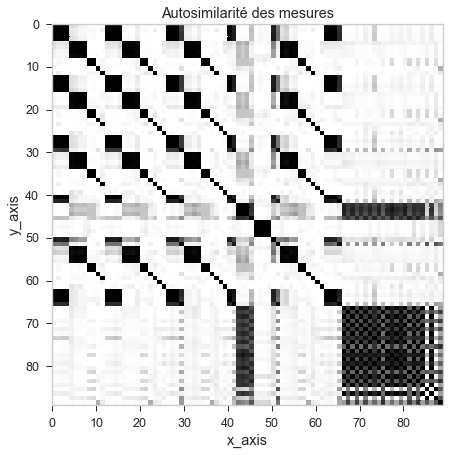

Rank of Q: 11


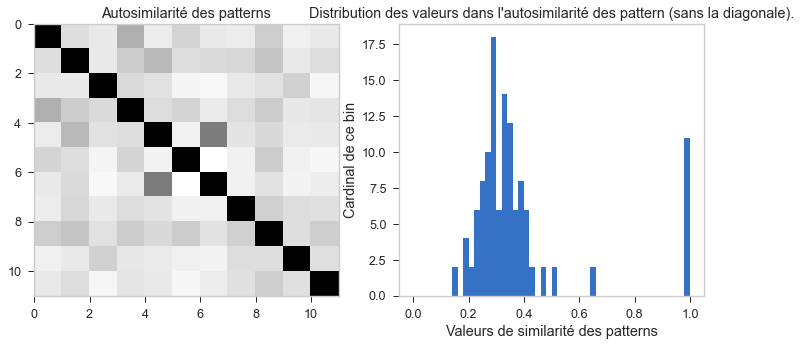

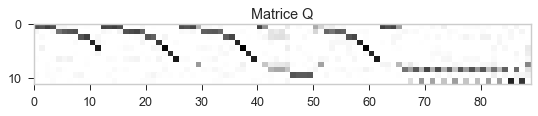

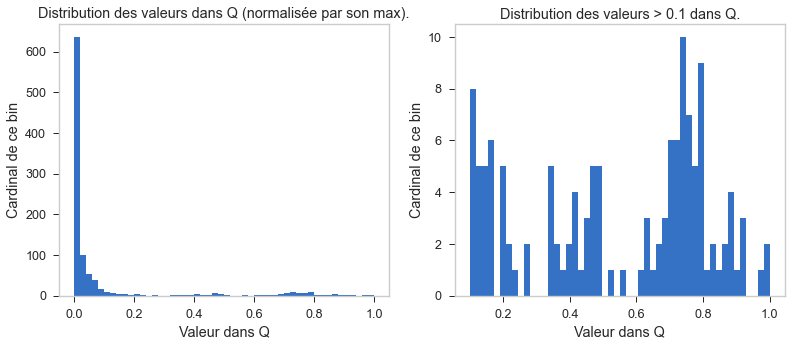

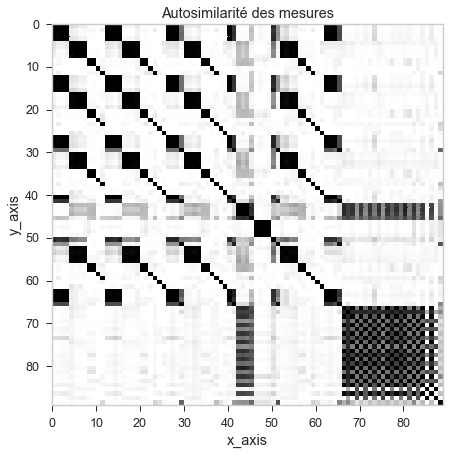

Rank of Q: 12


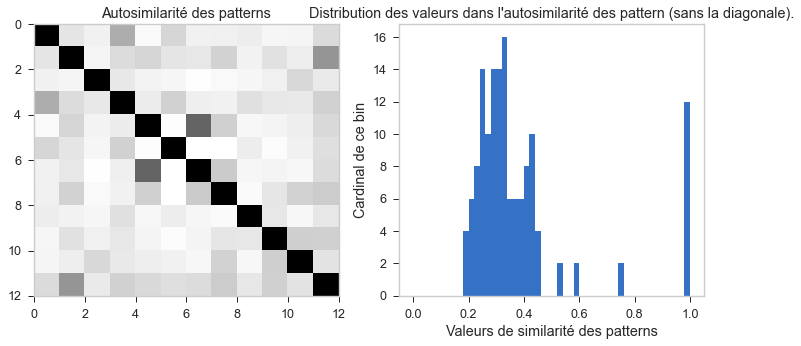

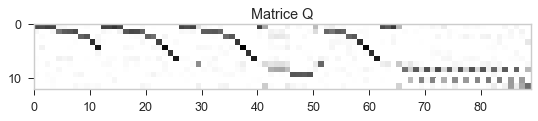

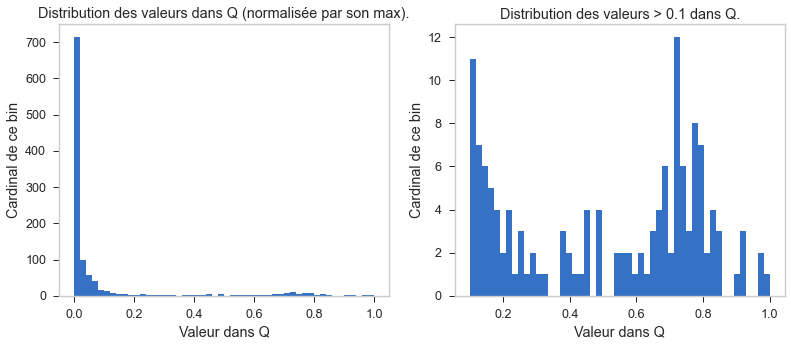

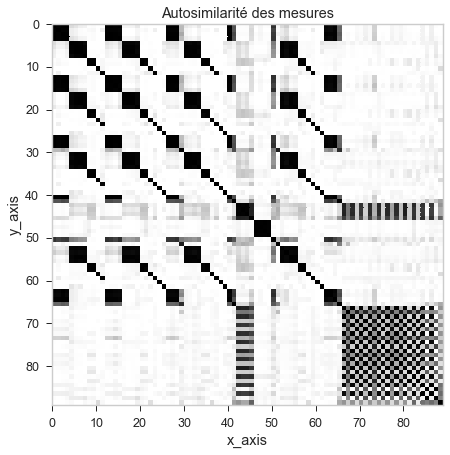

Rank of Q: 13


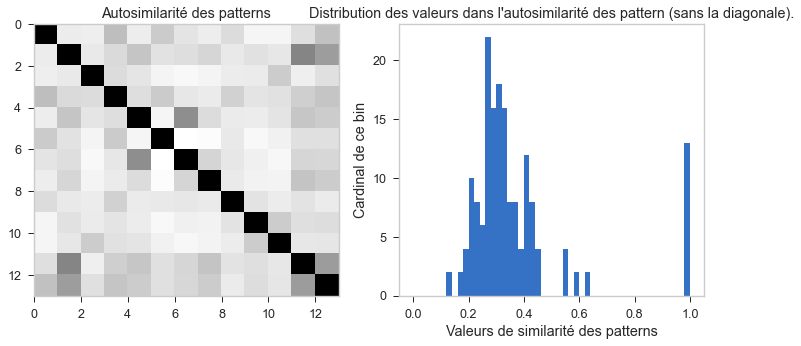

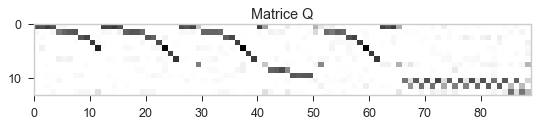

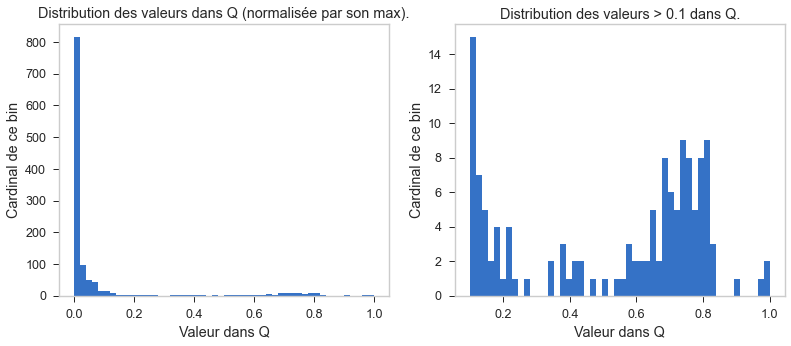

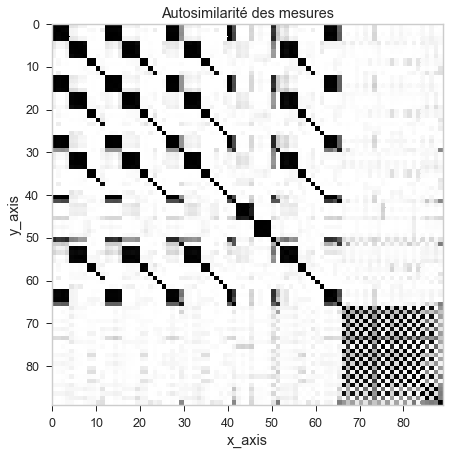

Rank of Q: 14


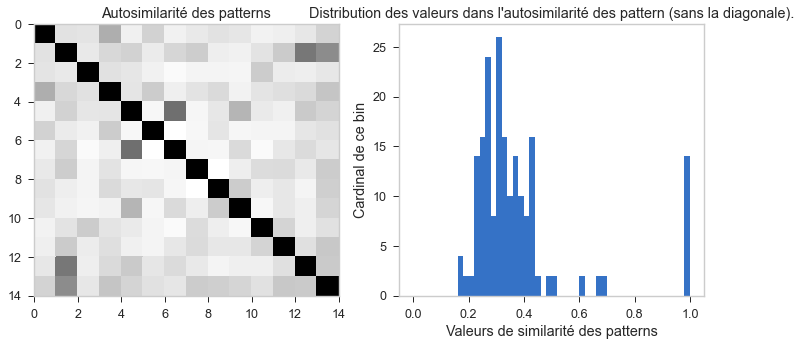

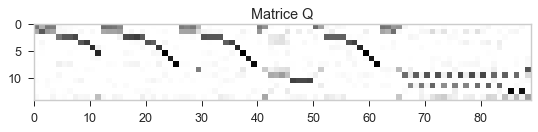

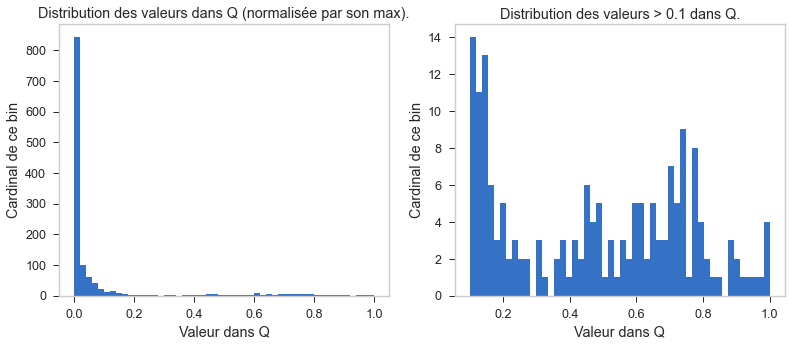

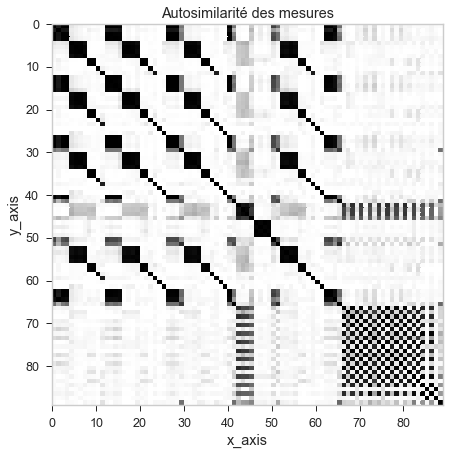

Rank of Q: 15


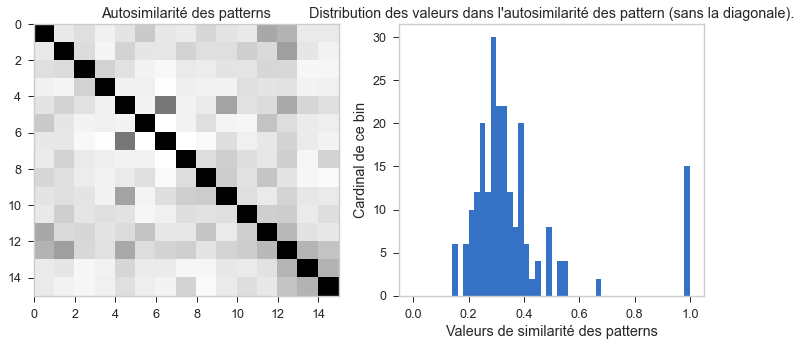

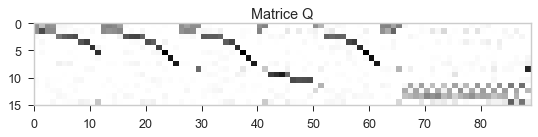

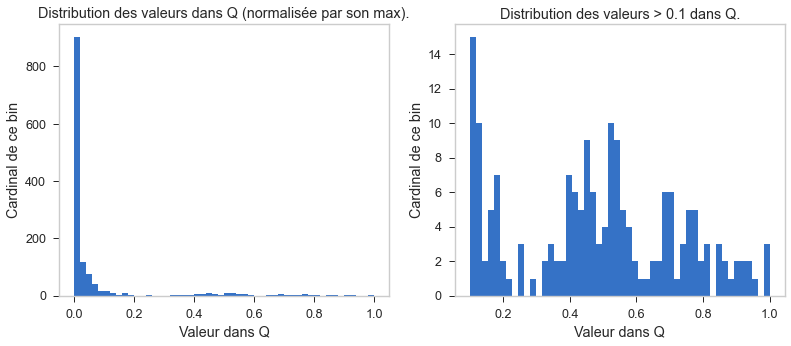

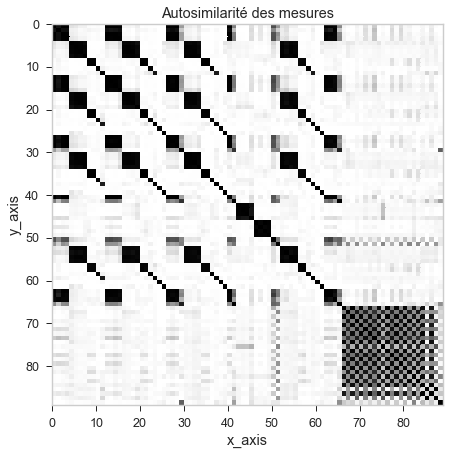

Rank of Q: 16


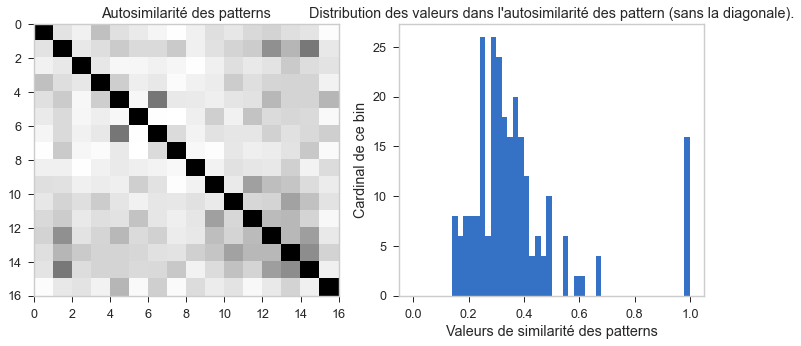

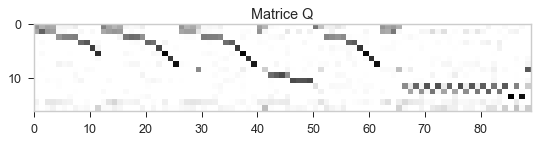

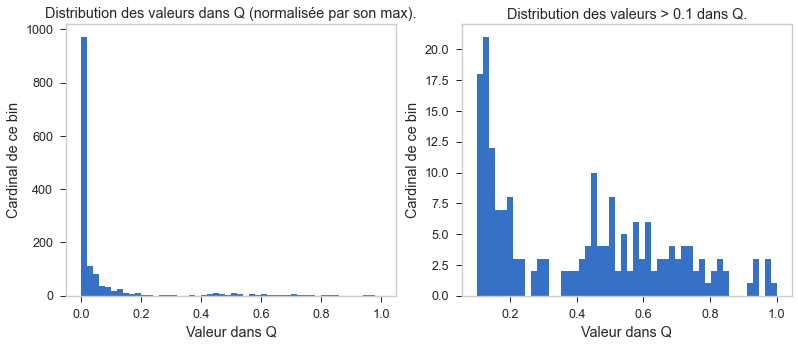

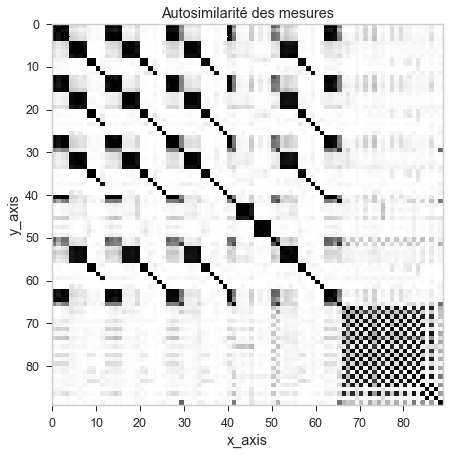

Rank of Q: 17


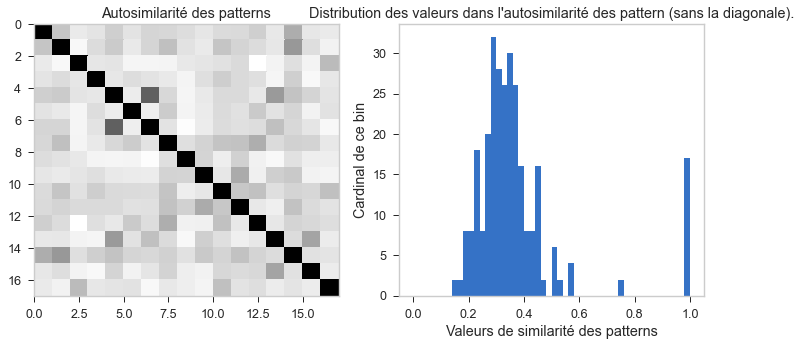

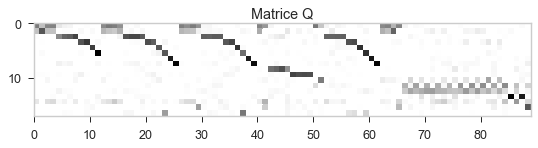

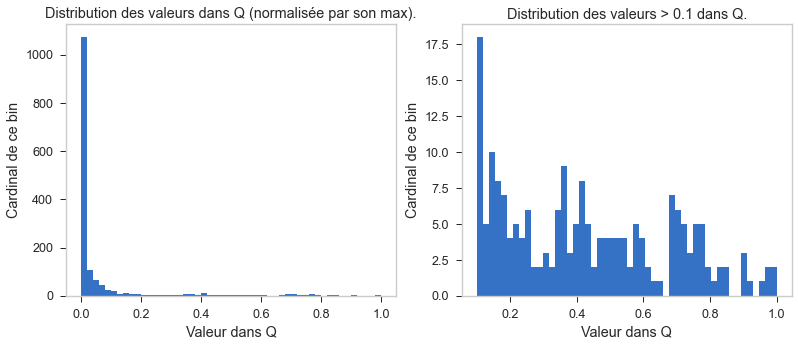

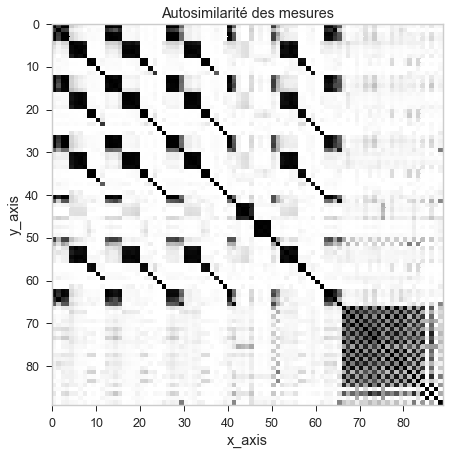

Rank of Q: 18


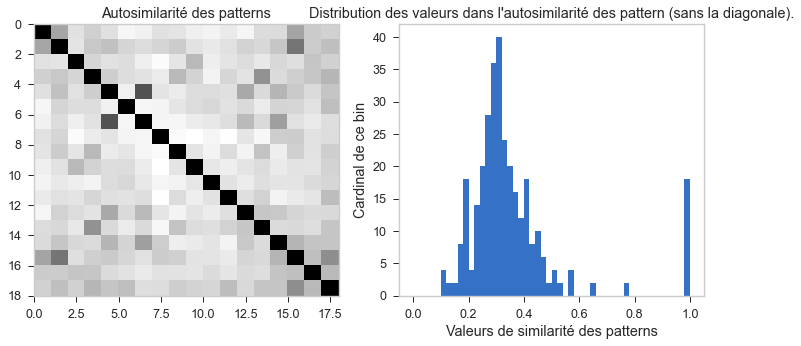

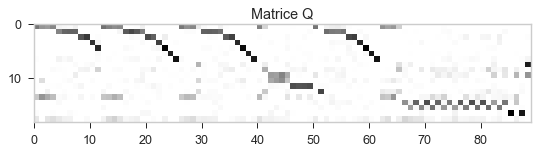

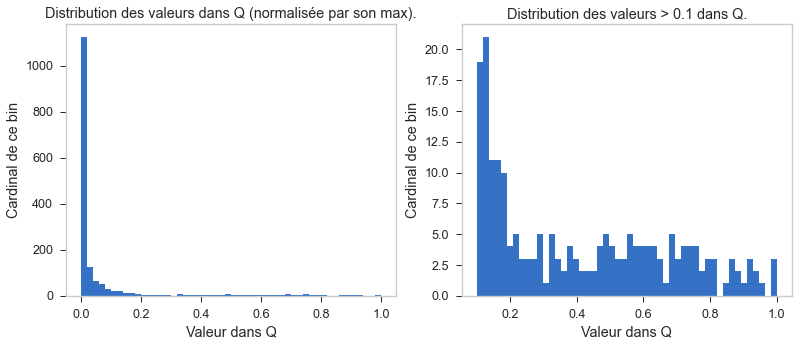

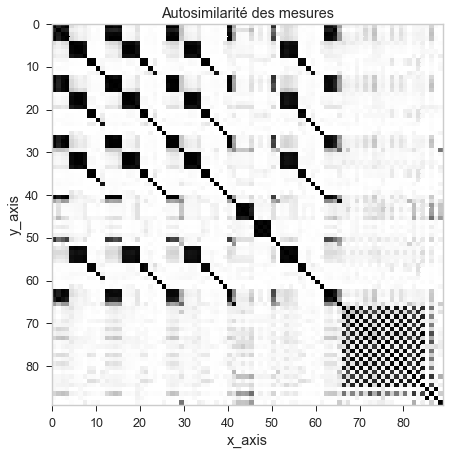

Rank of Q: 19


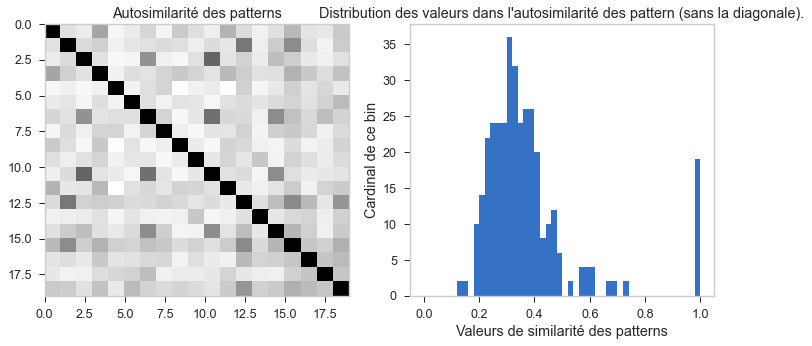

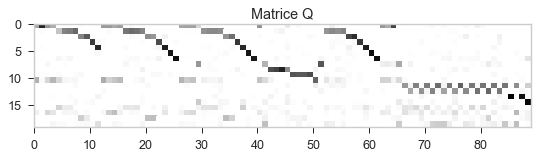

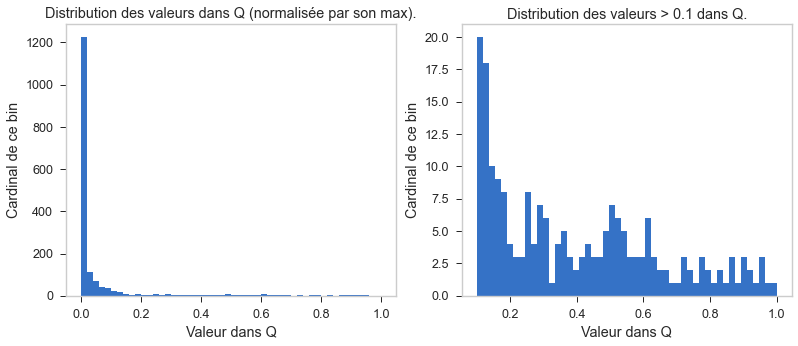

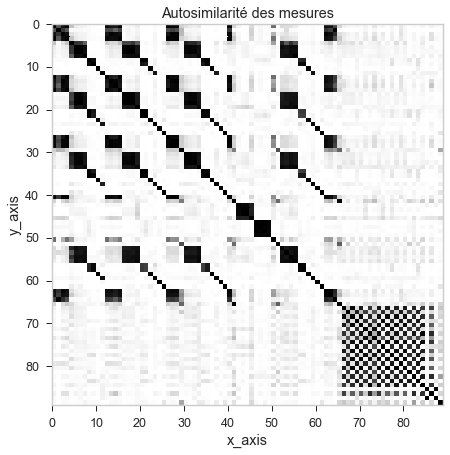

Rank of Q: 20


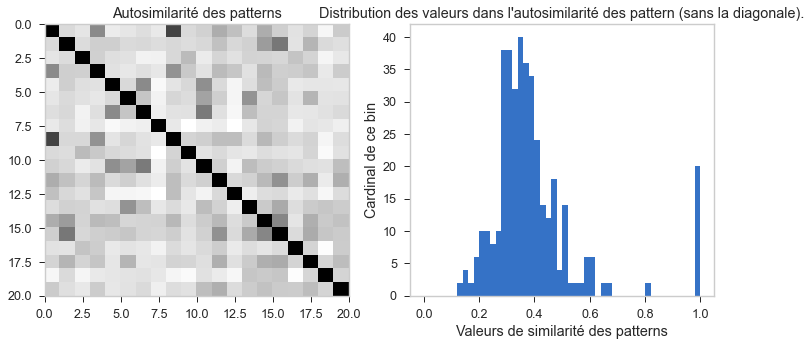

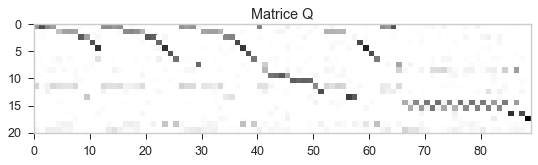

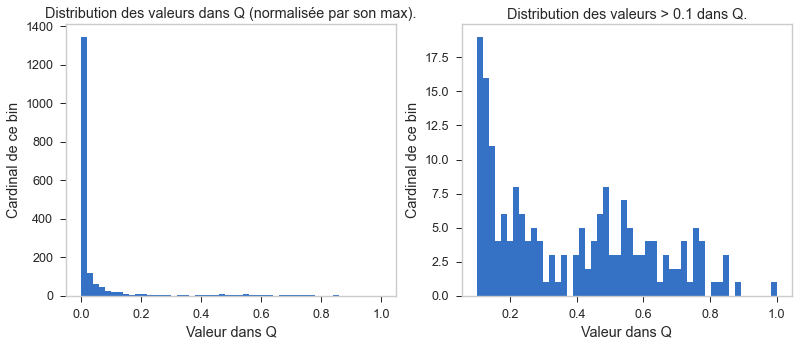

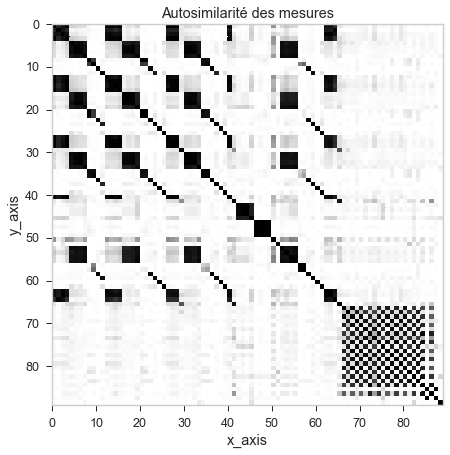

Rank of Q: 21


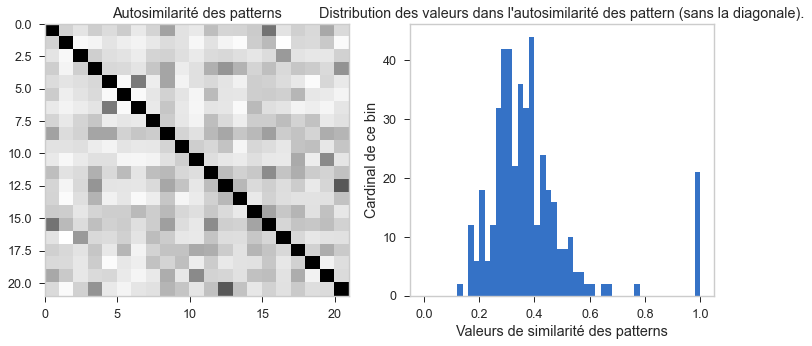

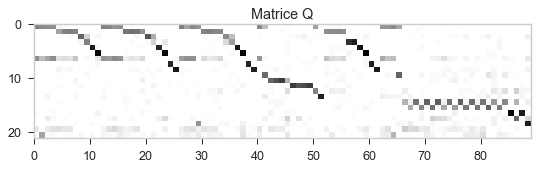

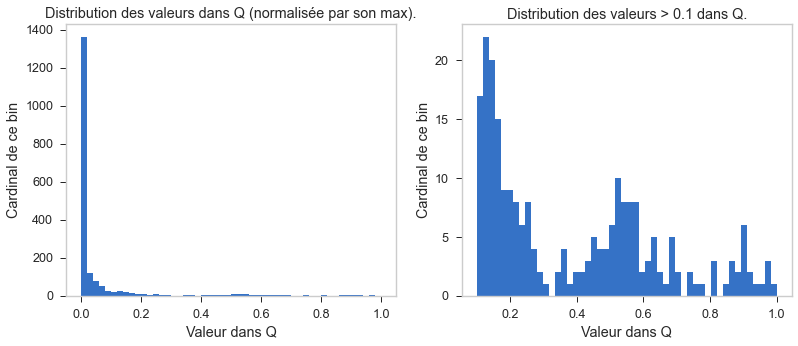

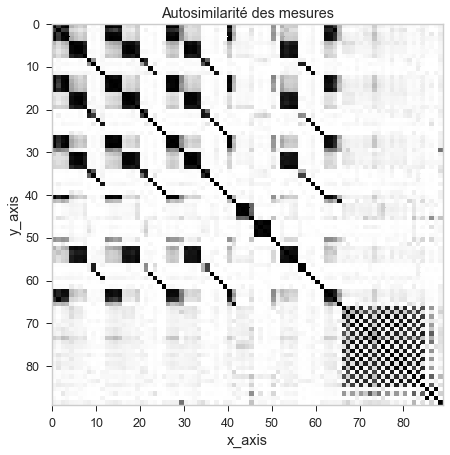

Rank of Q: 22


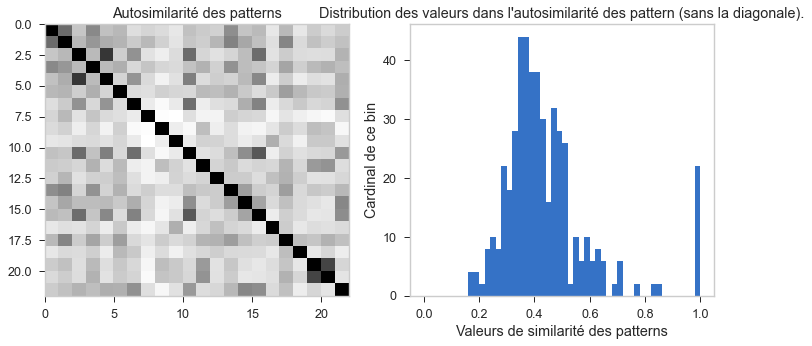

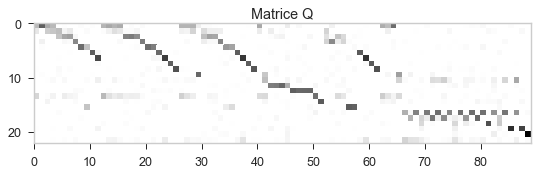

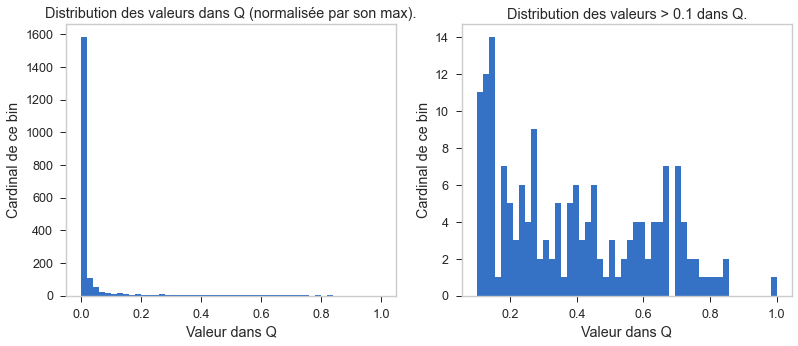

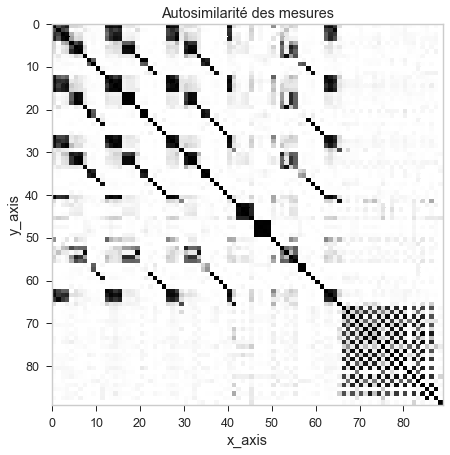

Rank of Q: 23


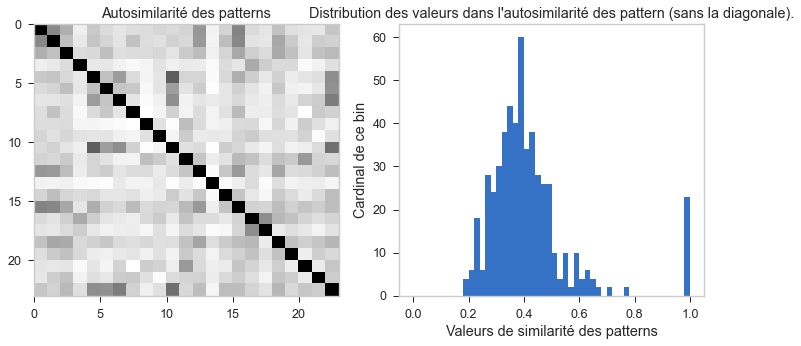

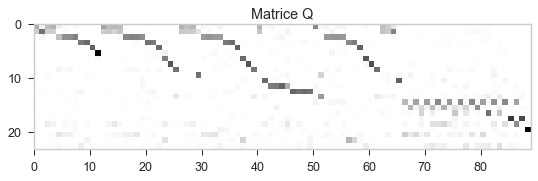

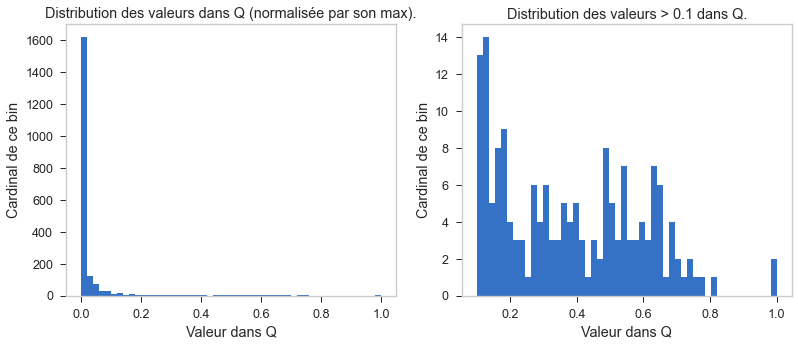

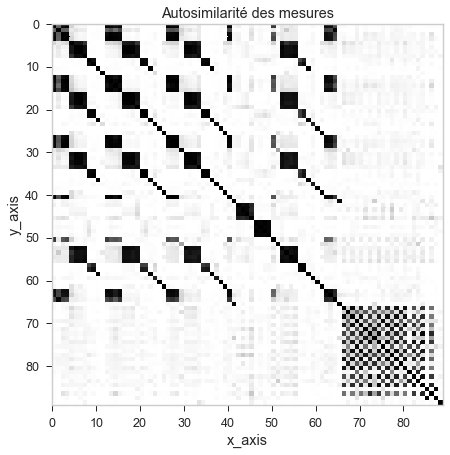

Rank of Q: 24


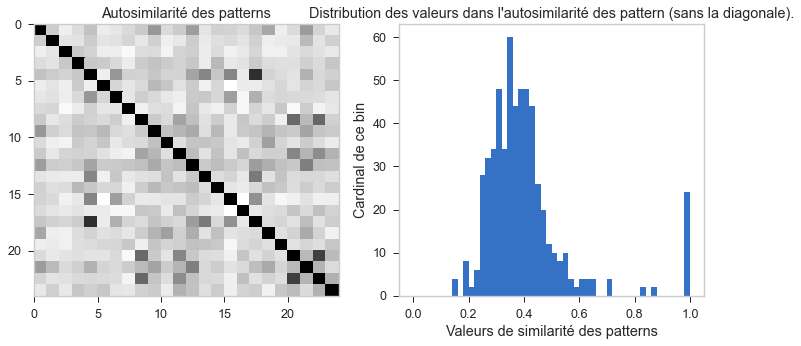

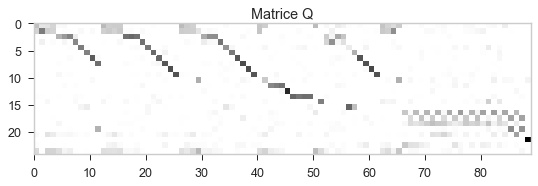

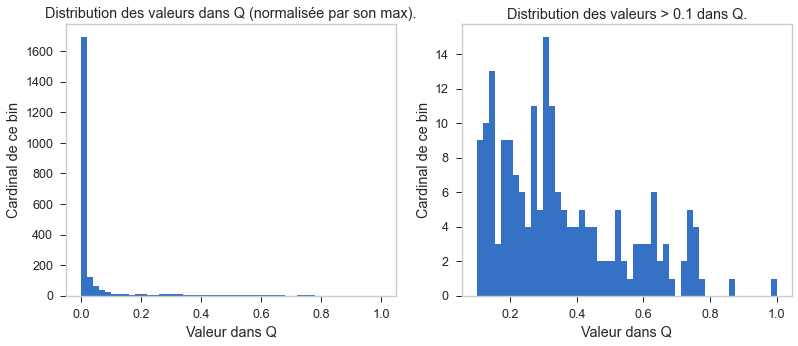

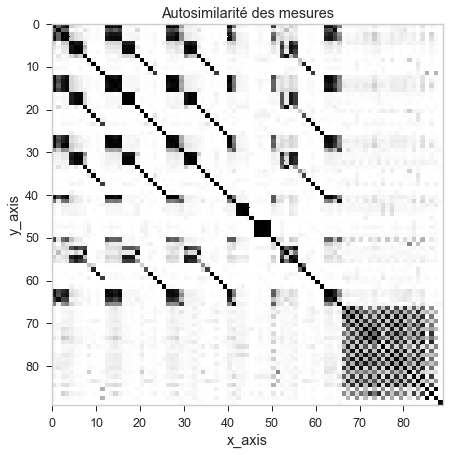

Rank of Q: 25


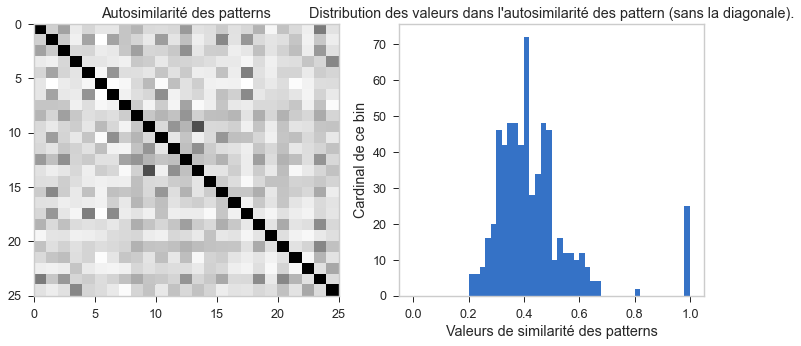

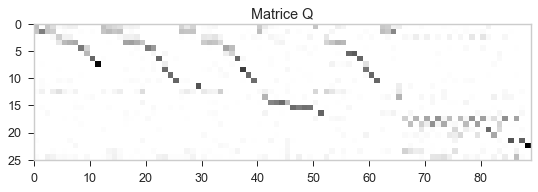

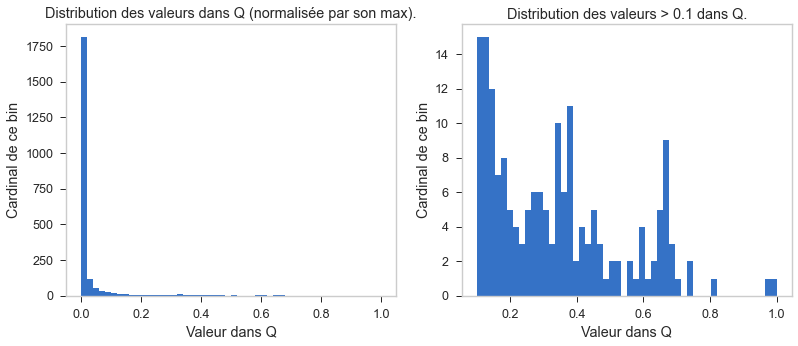

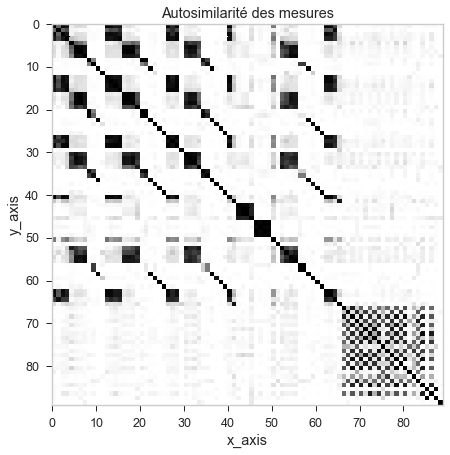

Rank of Q: 26


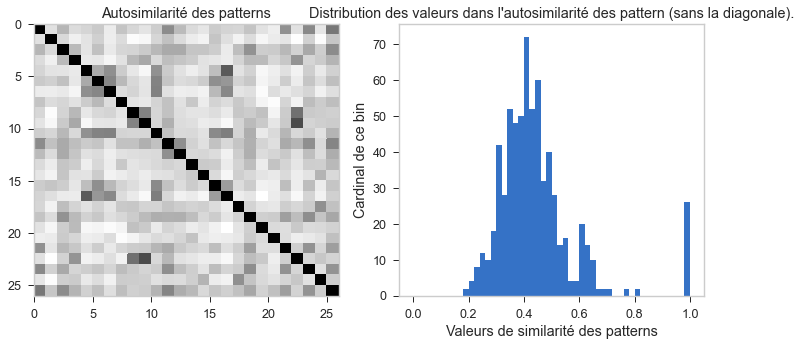

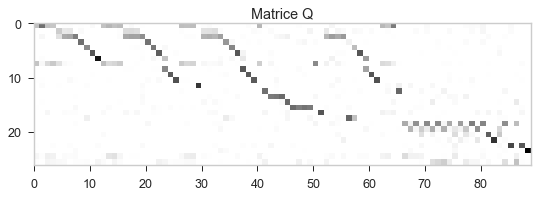

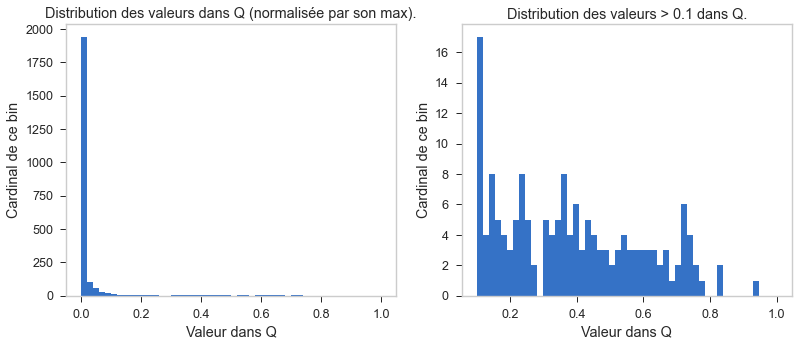

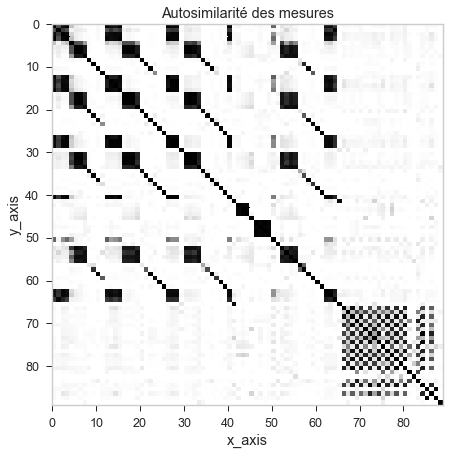

Rank of Q: 27


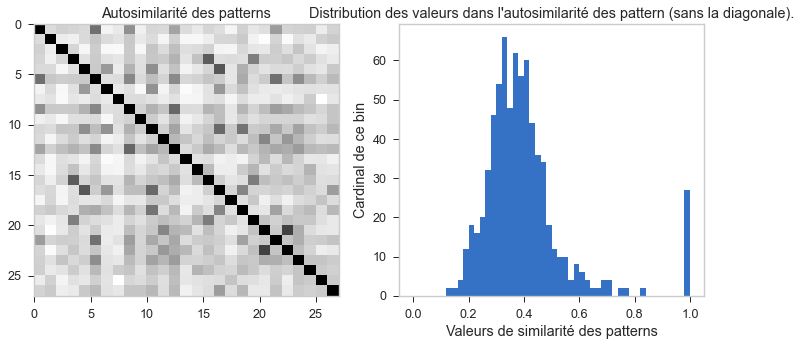

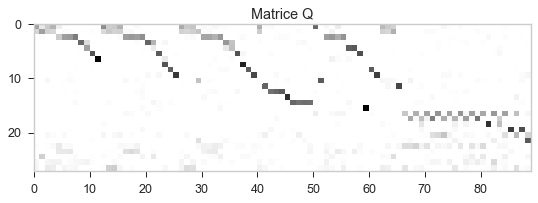

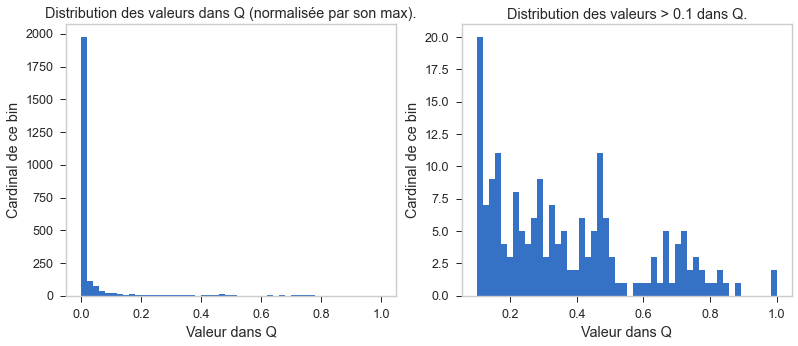

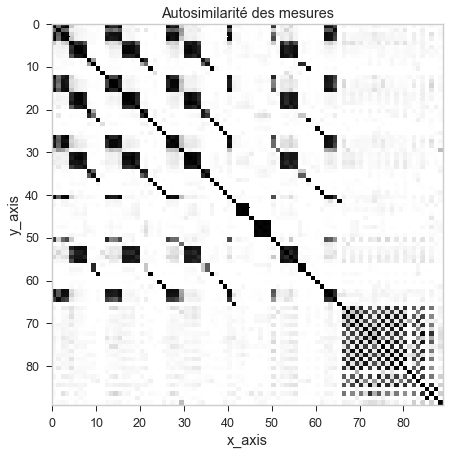

Rank of Q: 28


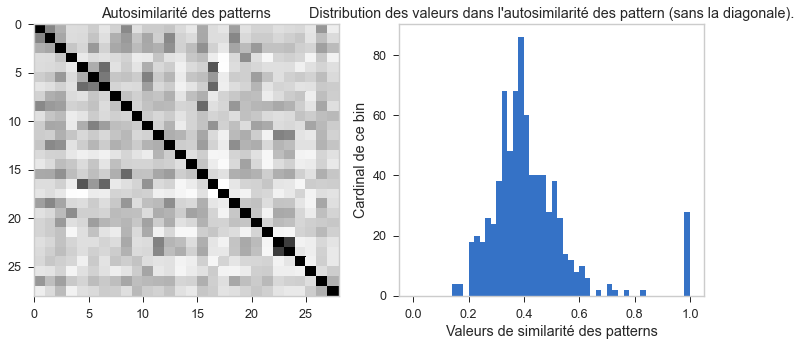

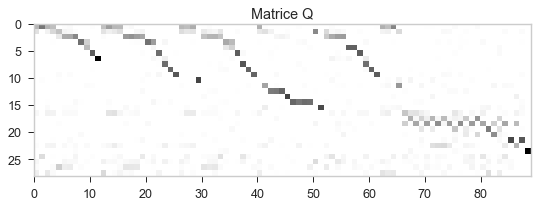

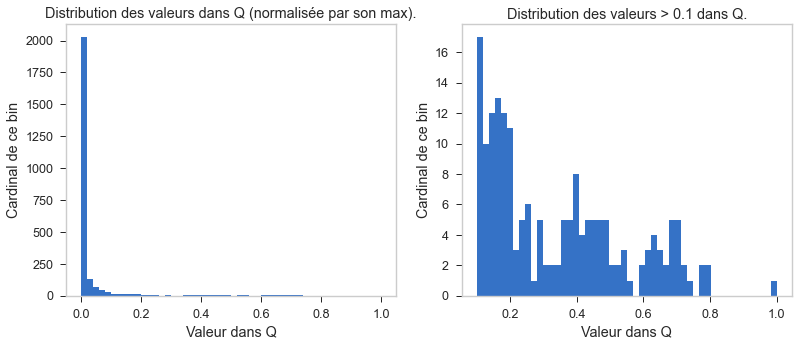

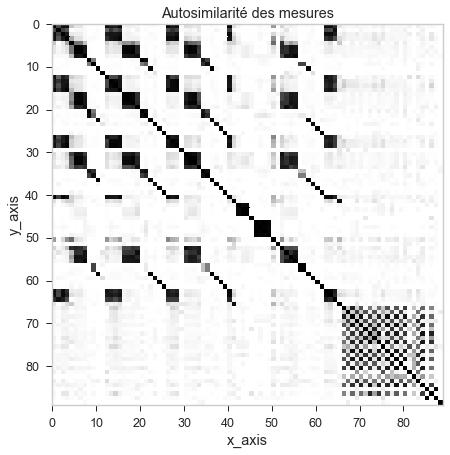

Rank of Q: 29


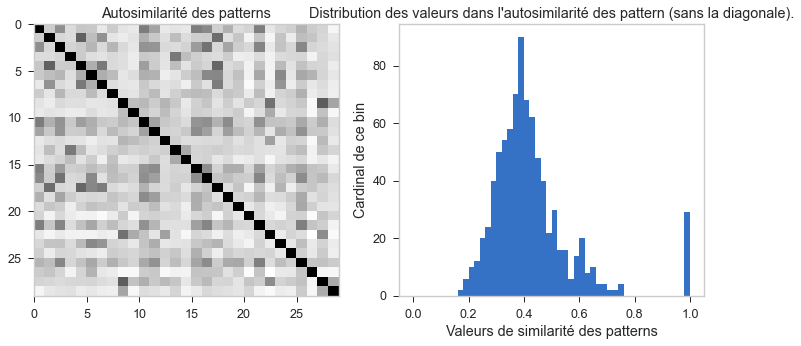

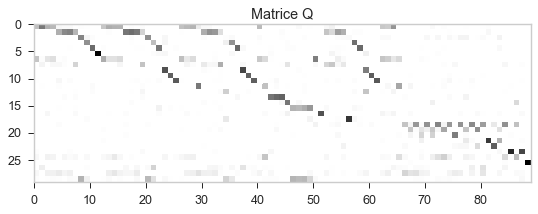

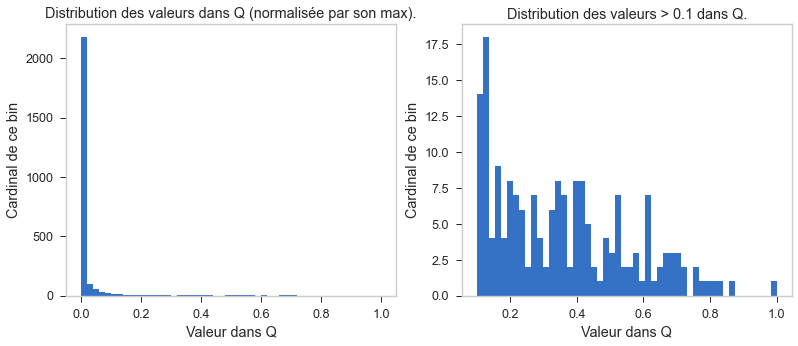

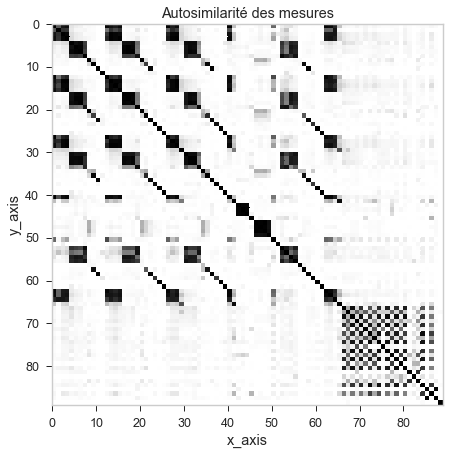

Rank of Q: 30


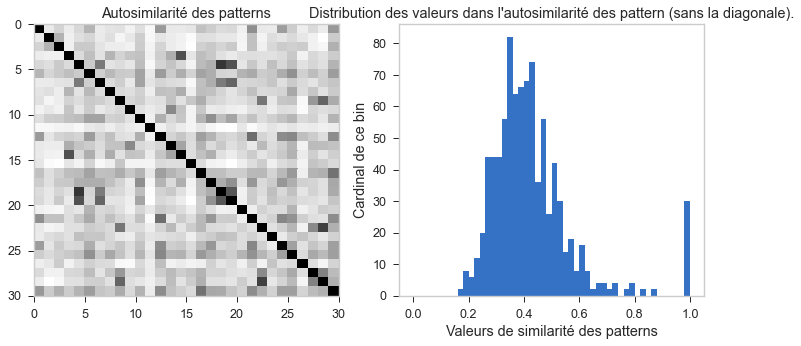

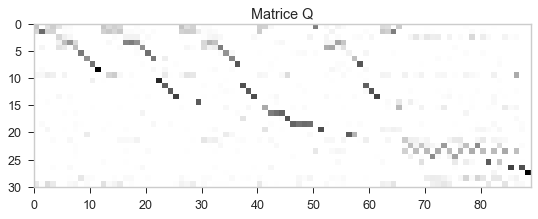

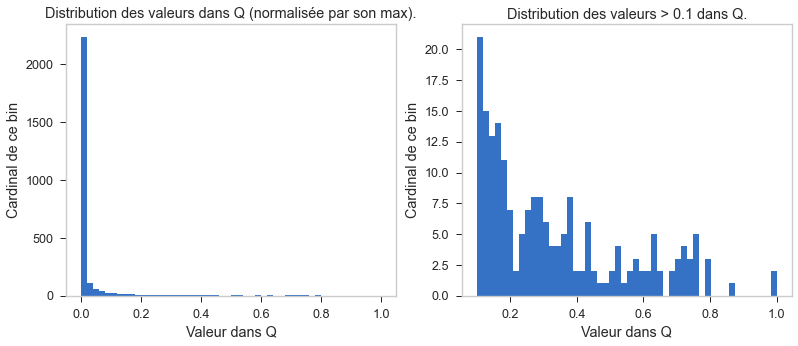

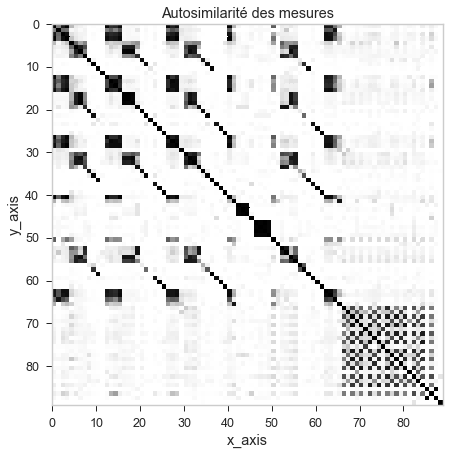

Rank of Q: 31


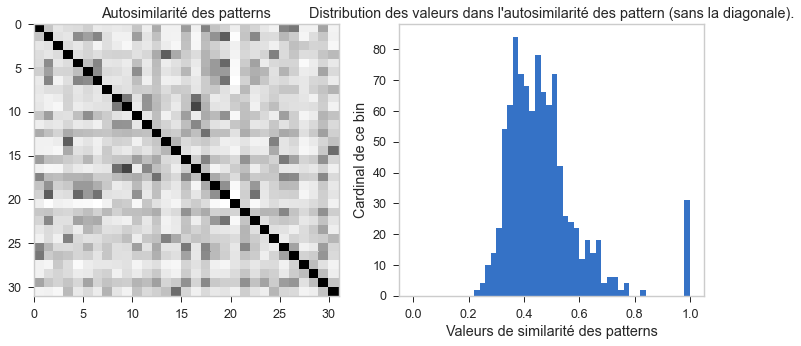

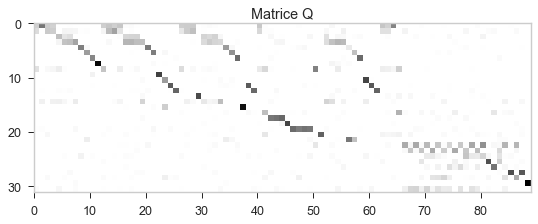

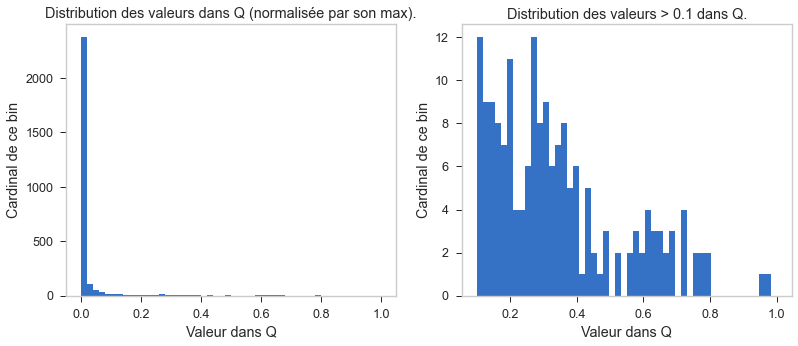

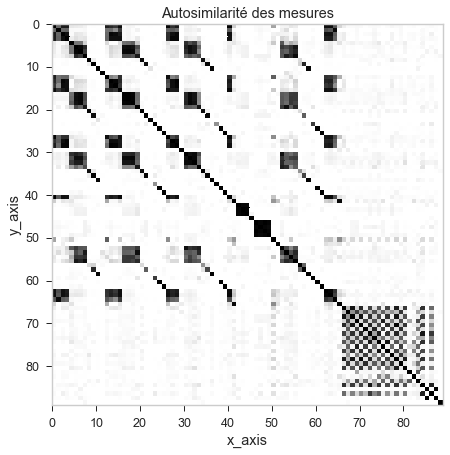

In [3]:
rank_of_h = 32
ranks_for_q = np.arange(2,32)

pattern_mean_similarity = []
pattern_std_similarity = []
dim_normalized_l_0_norm_q = []

dim_normalized_l_0_norm_intermediate_values = []
bar_mean_similarity = []
bar_std_similarity = []
vectorized_and_undiag_autosimil = []

determinants = []
exhaustive_rec_errors = []

f_mes_05 = []
f_mes_3 = []

for rank_q in ranks_for_q:
    ranks = [12,rank_of_h, rank_q]
    print("Rank of Q: " + str(rank_q))

    core, factors = scr.NTD_decomp_as_script(persisted_path, "_{}_{}_{}_{}".format(song_name, "pcp", "chromas", subdivision), tensor_spectrogram, ranks, init = "chromas")
    
    exhaustive_rec_errors.append(tl.norm(tensor_spectrogram - tl.tenalg.multi_mode_dot(core, factors, transpose = False), 2) / tl.norm(tensor_spectrogram, 2))

    core_autosimil = as_seg.get_autosimilarity(tl.unfold(core, 2), transpose = True, normalize = True)
    determinants.append(np.linalg.det(core_autosimil.T))
    diag_core_autosimil = core_autosimil - np.identity(core_autosimil.shape[0])
    pattern_autosimil_vec = np.reshape(np.round(core_autosimil,decimals = 6), (core_autosimil.shape[0] * core_autosimil.shape[1]))
    #max_autosimil_pattern.append(np.amax(diag_core_autosimil)) # Ne marche pas
    pattern_mean_similarity.append(np.mean(diag_core_autosimil))
    pattern_std_similarity.append(np.std(diag_core_autosimil))

    q_factor = factors[2]
    q_as_vec = np.reshape(np.round(q_factor, decimals = 5), (q_factor.shape[0] * q_factor.shape[1]))/np.amax(q_factor)
    dim_normalized_l_0_norm_q.append(np.linalg.norm(q_as_vec, 0)/q_as_vec.shape[0])
    
    #middle_q_as_vec = np.where(q_as_vec < 0.75, q_as_vec, 0)
    #middle_q_as_vec = np.where(middle_q_as_vec > 0.25, q_as_vec, 0)
    #dim_normalized_l_0_norm_intermediate_values.append(np.linalg.norm(middle_q_as_vec, 0)/q_as_vec.shape[0])

    bar_autosimilarity = as_seg.get_autosimilarity(q_factor, transpose = True, normalize = True)
    bar_autosimilarity_without_diag = bar_autosimilarity - np.identity(bar_autosimilarity.shape[0])
    vectorized_and_undiag_autosimil.append(bar_autosimilarity_without_diag.reshape(bar_autosimilarity.shape[0] * bar_autosimilarity.shape[1]))
    bar_mean_similarity.append(np.mean(bar_autosimilarity_without_diag))
    bar_std_similarity.append(np.std(bar_autosimilarity_without_diag))
    
    segments = as_seg.dynamic_convolution_computation(bar_autosimilarity, mix = 1, penalty_weight = 1, penalty_func = "modulo8")[0]
    segments_in_time = dm.segments_from_bar_to_time(segments, bars)

    f_mes_05.append(dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)[2])
    f_mes_3.append(dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)[2])
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    padded_spec = pad_factor(core_autosimil)
    axs[0].pcolormesh(np.arange(padded_spec.shape[1]), np.arange(padded_spec.shape[0]), padded_spec, cmap=cm.Greys)
    axs[0].set_title("Autosimilarité des patterns")
    axs[0].invert_yaxis()
    axs[1].set_xlabel("Valeurs de similarité des patterns")
    axs[1].set_ylabel("Cardinal de ce bin")
    axs[1].hist(pattern_autosimil_vec, range = (0, 1), bins = 50)
    axs[1].set_title("Distribution des valeurs dans l'autosimilarité des pattern (sans la diagonale).")
    plt.show()
    
    plot_permuted_factor(q_factor, title = "Matrice Q")
    #plot_permuted_factor(np.reshape(middle_q_as_vec, (q_factor.shape[0], q_factor.shape[1])))
    fig, axs = plt.subplots(1, 2, figsize=(13,5))
    axs[0].set_xlabel("Valeur dans Q")
    axs[0].set_ylabel("Cardinal de ce bin")
    axs[0].hist(q_as_vec, range = (0, 1), bins = 50)
    axs[0].set_title("Distribution des valeurs dans Q (normalisée par son max).")
    axs[1].set_xlabel("Valeur dans Q")
    axs[1].set_ylabel("Cardinal de ce bin")
    axs[1].hist(q_as_vec, range = (0.1, 1), bins = 50)
    axs[1].set_title("Distribution des valeurs > 0.1 dans Q.")
    plt.show()
    plot_me_this_spectrogram(bar_autosimilarity, title = "Autosimilarité des mesures")


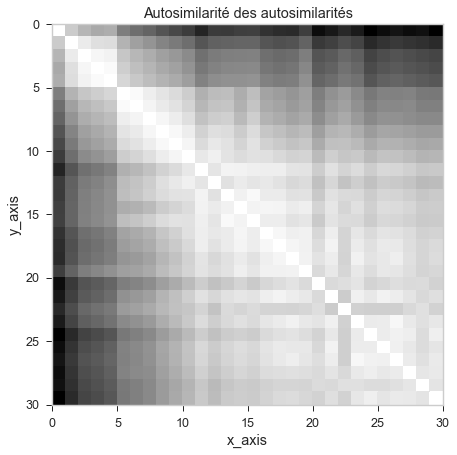

In [4]:
autosimil_of_autosimil = as_seg.get_autosimilarity(vectorized_and_undiag_autosimil, transpose = True, normalize = True)
plot_me_this_spectrogram(autosimil_of_autosimil, cmap = cm.gray, title = "Autosimilarité des autosimilarités")

In [5]:
#import random
#random.seed(42)
#random_label = [random.randint(0,1) for i in range(30)]
#xp=TSNE().fit_transform(np.array(vectorized_and_undiag_autosimil))
#plt.figure(3,(12,10))

#plt.scatter(xp[:,0],xp[:,1],c=random_label)
#plt.colorbar()
#plt.title('TSNE Embedding of the Source/Target data')

### Débit-distorsion

#### Débit - Similarité moyenne des pattern dans l'autosimil

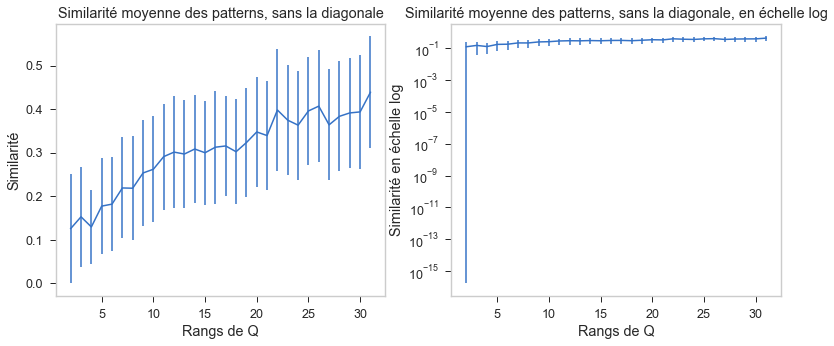

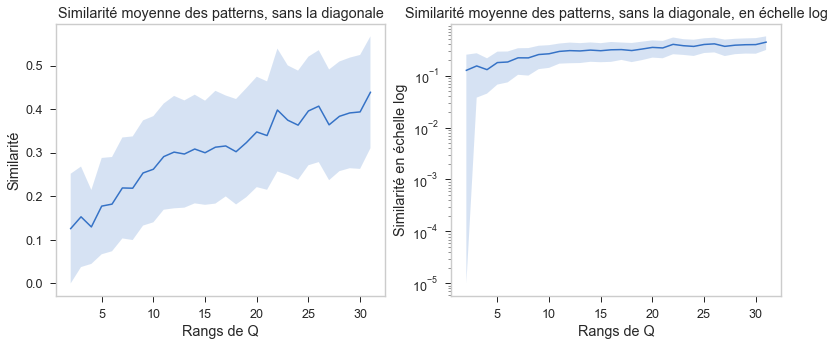

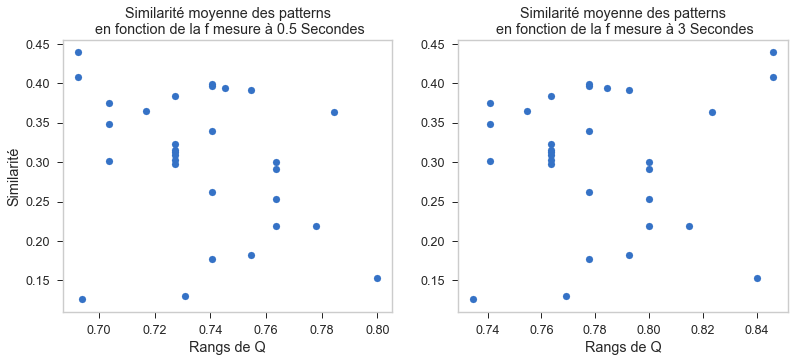

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].errorbar(ranks_for_q, pattern_mean_similarity, yerr=pattern_std_similarity)
axs[0].set_title("Similarité moyenne des patterns, sans la diagonale")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].errorbar(ranks_for_q, pattern_mean_similarity, yerr=pattern_std_similarity)
axs[1].set_title("Similarité moyenne des patterns, sans la diagonale, en échelle log")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_q, pattern_mean_similarity, '-')
axs[0].fill_between(ranks_for_q, np.subtract(pattern_mean_similarity, pattern_std_similarity), np.add(pattern_mean_similarity, pattern_std_similarity), alpha=0.2)
axs[0].set_title("Similarité moyenne des patterns, sans la diagonale")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_q, pattern_mean_similarity, '-')
axs[1].fill_between(ranks_for_q, np.maximum(np.subtract(pattern_mean_similarity, pattern_std_similarity), 1e-5), np.add(pattern_mean_similarity, pattern_std_similarity), alpha=0.2)
axs[1].set_title("Similarité moyenne des patterns, sans la diagonale, en échelle log")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].scatter(f_mes_05, pattern_mean_similarity)
axs[0].set_title("Similarité moyenne des patterns\n en fonction de la f mesure à 0.5 Secondes")
axs[1].set_xlabel("Rangs de Q")
axs[1].scatter(f_mes_3, pattern_mean_similarity)
axs[1].set_title("Similarité moyenne des patterns\n en fonction de la f mesure à 3 Secondes")
plt.show()

#### Distorsion

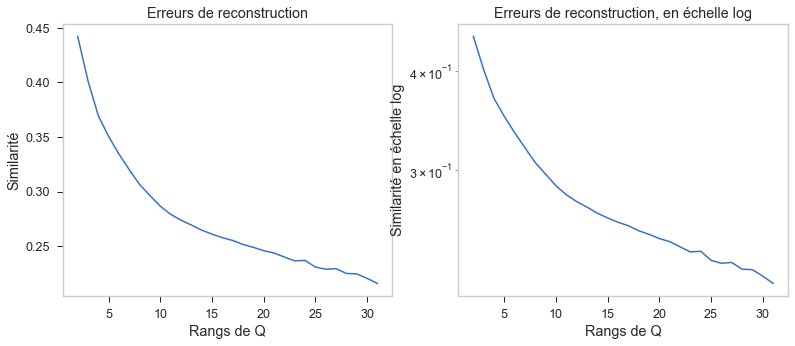

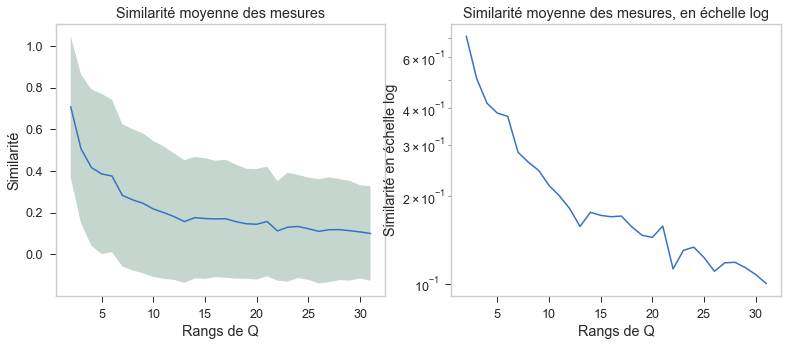

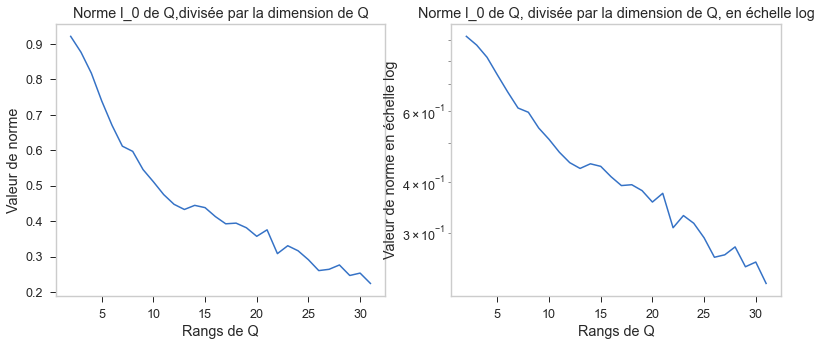

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_q, exhaustive_rec_errors)
axs[0].set_title("Erreurs de reconstruction")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_q, exhaustive_rec_errors)
axs[1].set_title("Erreurs de reconstruction, en échelle log")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_q, bar_mean_similarity)
axs[0].fill_between(ranks_for_q, np.subtract(bar_mean_similarity, bar_std_similarity), np.add(bar_mean_similarity, bar_std_similarity), alpha=0.2)
axs[0].set_title("Similarité moyenne des mesures")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_q, bar_mean_similarity)
axs[0].fill_between(ranks_for_q, np.subtract(bar_mean_similarity, bar_std_similarity), np.add(bar_mean_similarity, bar_std_similarity), alpha=0.2)
axs[1].set_title("Similarité moyenne des mesures, en échelle log")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Valeur de norme")
axs[0].plot(ranks_for_q, dim_normalized_l_0_norm_q)
axs[0].set_title("Norme l_0 de Q,divisée par la dimension de Q")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Valeur de norme en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_q, dim_normalized_l_0_norm_q)
axs[1].set_title("Norme l_0 de Q, divisée par la dimension de Q, en échelle log")
plt.show()

#### Compromis débit-distorsion

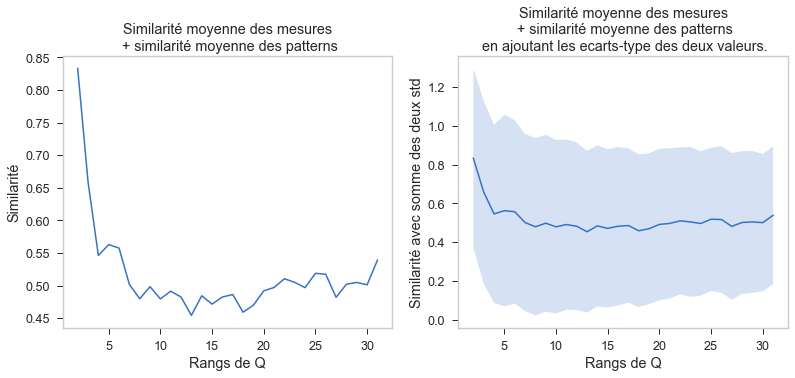

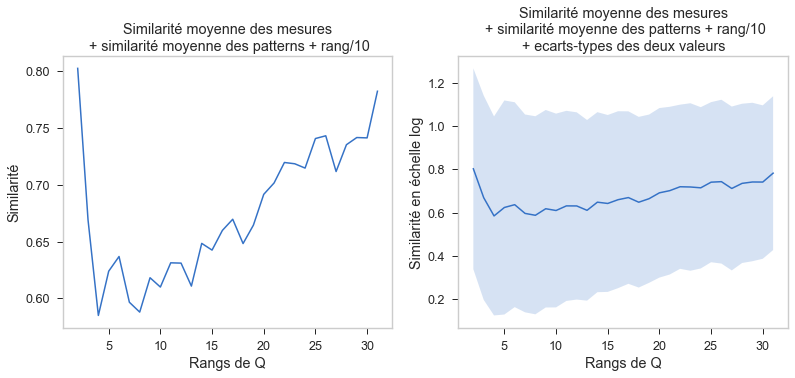

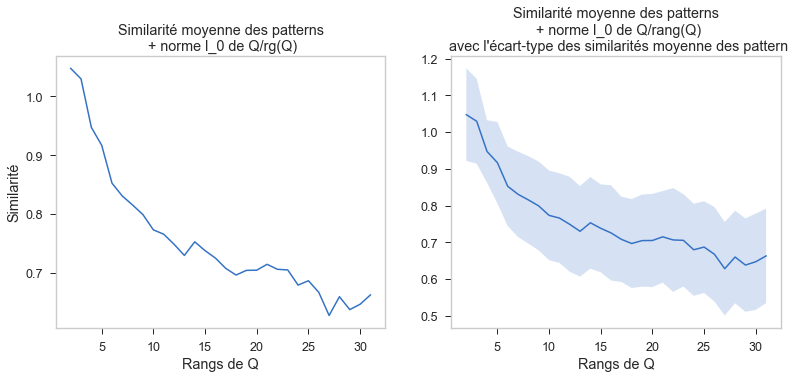

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
both_simil = np.add(pattern_mean_similarity, bar_mean_similarity)
axs[0].plot(ranks_for_q, both_simil)
axs[0].set_title("Similarité moyenne des mesures\n + similarité moyenne des patterns")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité avec somme des deux std")
both_std = np.add(pattern_std_similarity, bar_std_similarity)
axs[1].plot(ranks_for_q, both_simil)
axs[1].fill_between(ranks_for_q, np.subtract(both_simil, both_std), np.add(both_simil, both_std), alpha=0.2)
axs[1].set_title("Similarité moyenne des mesures\n + similarité moyenne des patterns\n en ajoutant les ecarts-type des deux valeurs.")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].plot(ranks_for_q, [pattern_mean_similarity[i] + bar_mean_similarity[i] + (math.log(ranks_for_q[i]) - 1)/10 for i in range(len(ranks_for_q))])
axs[0].set_title("Similarité moyenne des mesures\n + similarité moyenne des patterns + rang/10")
axs[0].set_ylabel("Similarité")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_xlabel("Rangs de Q")
axs[1].plot(ranks_for_q, [pattern_mean_similarity[i] + bar_mean_similarity[i] + (math.log(ranks_for_q[i]) - 1)/10 for i in range(len(ranks_for_q))])
lim_basse = [pattern_mean_similarity[i] - pattern_std_similarity[i] + bar_mean_similarity[i] - bar_std_similarity[i] + (math.log(ranks_for_q[i]) - 1)/10 for i in range(len(ranks_for_q))]
lim_haute = [pattern_mean_similarity[i] + pattern_std_similarity[i] + bar_mean_similarity[i] + bar_std_similarity[i] + (math.log(ranks_for_q[i]) - 1)/10 for i in range(len(ranks_for_q))]
axs[1].fill_between(ranks_for_q, lim_basse, lim_haute, alpha=0.2)
axs[1].set_title("Similarité moyenne des mesures\n + similarité moyenne des patterns + rang/10\n+ ecarts-types des deux valeurs")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
mean_simil_and_lo = np.add(pattern_mean_similarity,dim_normalized_l_0_norm_q)
axs[0].plot(ranks_for_q, mean_simil_and_lo)
axs[0].set_title("Similarité moyenne des patterns\n + norme l_0 de Q/rg(Q)")
axs[1].set_xlabel("Rangs de Q")
axs[1].plot(ranks_for_q, mean_simil_and_lo)
axs[1].fill_between(ranks_for_q, np.subtract(mean_simil_and_lo, pattern_std_similarity), np.add(mean_simil_and_lo, pattern_std_similarity), alpha=0.2)
axs[1].set_title("Similarité moyenne des patterns\n + norme l_0 de Q/rang(Q)\n avec l'écart-type des similarités moyenne des pattern")
plt.show()

#fig, axs = plt.subplots(1, 2, figsize=(13,5))
#axs[0].set_xlabel("Rangs de Q")
#axs[0].set_ylabel("Similarité")
#axs[0].plot(ranks_for_q, np.add(pattern_mean_similarity/np.amax(pattern_mean_similarity),dim_normalized_l_0_norm_q/np.amax(dim_normalized_l_0_norm_q)))
#axs[0].set_title("Similarité patterns/max(sim patterns)\n + norme l_0 de Q/(dim de Q * max(norme l_0 de Q))")
#axs[1].set_xlabel("Rangs de Q")
#axs[1].set_yscale('log')
#axs[1].plot(ranks_for_q, np.add(pattern_mean_similarity/np.amax(pattern_mean_similarity),dim_normalized_l_0_norm_q/np.amax(dim_normalized_l_0_norm_q)))
#axs[1].set_title("Similarité patterns/max(sim patterns)\n + norme l_0 de Q/(dim de Q * max(norme l_0 de Q))")
#plt.show()

#fig, axs = plt.subplots(1, 2, figsize=(13,5))
#axs[0].set_xlabel("Rangs de Q")
#axs[0].set_ylabel("Similarité")
#axs[0].plot(ranks_for_q, [pattern_mean_similarity[i]/np.amax(pattern_mean_similarity) + dim_normalized_l_0_norm_q[i]/np.amax(dim_normalized_l_0_norm_q) + (math.log(ranks_for_q[i]) - 1)/10 for i in range(len(ranks_for_q))])
#axs[0].set_title("Similarité patterns/max(sim patterns)\n + norme l_0 de Q/(dim de Q * max(norme l_0 de Q))\n + rang de Q/10")
#axs[1].set_xlabel("Rangs de Q")
#axs[1].set_yscale('log')
#axs[1].plot(ranks_for_q, [pattern_mean_similarity[i]/np.amax(pattern_mean_similarity) + dim_normalized_l_0_norm_q[i]/np.amax(dim_normalized_l_0_norm_q) + (math.log(ranks_for_q[i]) - 1)/10 for i in range(len(ranks_for_q))])
#axs[1].set_title("Similarité patterns/max(sim patterns)\n + norme l_0 de Q/(dim de Q * max(norme l_0 de Q))\n + rang de Q/10")
#plt.show()

#plt.plot(ranks_for_q, np.multiply(pattern_mean_similarity,dim_normalized_l_0_norm_q))
#plt.title("Teinte moyenne pattern * l_0 norm of Q divided by the size of Q")
#plt.show()

### Volume des patterns

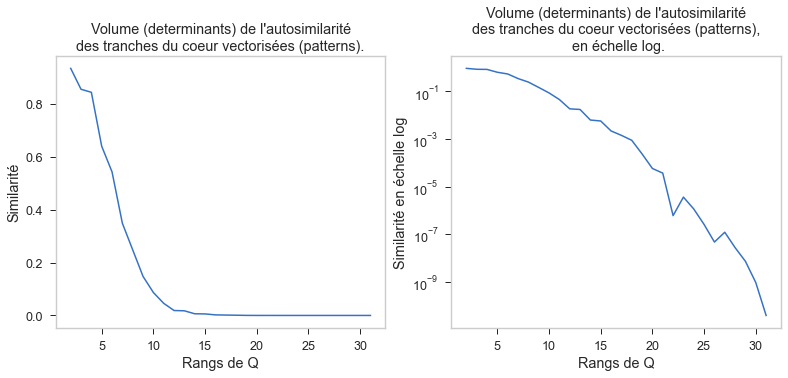

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_q, determinants)
axs[0].set_title("Volume (determinants) de l'autosimilarité\ndes tranches du coeur vectorisées (patterns).")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_q, determinants)
axs[1].set_title("Volume (determinants) de l'autosimilarité\ndes tranches du coeur vectorisées (patterns),\n en échelle log.")
plt.show()

Point de bascule: 10.284572615454689


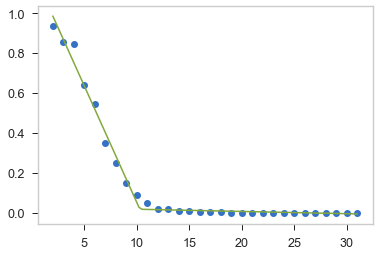

In [10]:
import pwlf

fit_determinants = pwlf.PiecewiseLinFit(ranks_for_q, determinants)
change_points = fit_determinants.fit(2)
print("Point de bascule: {}".format(change_points[1]))

x_interpolation = np.linspace(ranks_for_q.min(), ranks_for_q.max(), 100)
y_interpolation = fit_determinants.predict(x_interpolation)

plt.figure()
plt.plot(ranks_for_q, determinants, 'o')
plt.plot(x_interpolation, y_interpolation, '-')
plt.show()

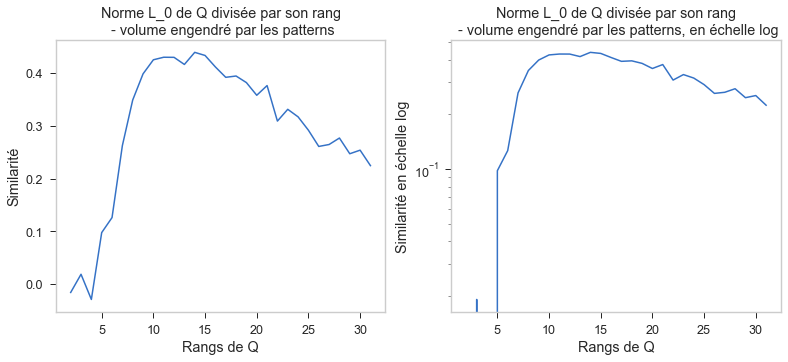

Rang maximisant cette valeur: 14


In [11]:
lo_minus_det = np.subtract(dim_normalized_l_0_norm_q, determinants)

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de Q")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_q, lo_minus_det)
axs[0].set_title("Norme L_0 de Q divisée par son rang\n - volume engendré par les patterns")
axs[1].set_xlabel("Rangs de Q")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_q, lo_minus_det)
axs[1].set_title("Norme L_0 de Q divisée par son rang\n - volume engendré par les patterns, en échelle log")
plt.show()

print("Rang maximisant cette valeur: {}".format(ranks_for_q[np.argmax(lo_minus_det)]))

## Looping on $H$

In [12]:
dont

NameError: name 'dont' is not defined

In [ ]:
ranks_for_h = np.arange(2,32)
rank_of_q = 15

loop_h_mean_similarity_patterns = []
loop_h_std_similarity_patterns = []
loop_h_l_0_norm_of_q = []
loop_h_mean_similarity_bars = []
loop_h_std_similarity_bars = []
loop_h_autosimilarity_vectorized = []

for rank_h in ranks_for_h:
    print("Rank of H: " + str(rank_h))
    ranks = [12,rank_h, rank_of_q]
    core, factors = scr.NTD_decomp_as_script(persisted_path, "_{}_{}_{}_{}".format(song_name, "pcp", "chromas", subdivision), tensor_spectrogram, ranks, init = "chromas")

    core_autosimil = as_seg.get_autosimilarity(tl.unfold(core, 2), transpose = True, normalize = True)
    diag_core_autosimil = core_autosimil - np.identity(core_autosimil.shape[0])
    loop_h_mean_similarity_patterns.append(np.mean(diag_core_autosimil))
    loop_h_std_similarity_patterns.append(np.std(diag_core_autosimil))

    q_factor = factors[2]
    loop_h_l_0_norm_of_q.append(np.linalg.norm(np.reshape(q_factor, (q_factor.shape[0] * q_factor.shape[1])), 0))

    bar_autosimilarity = as_seg.get_autosimilarity(q_factor, transpose = True, normalize = True)
    diag_bar = bar_autosimilarity - np.identity(bar_autosimilarity.shape[0])
    loop_h_autosimilarity_vectorized.append(diag_bar.reshape(bar_autosimilarity.shape[0] * bar_autosimilarity.shape[1]))
    loop_h_mean_similarity_bars.append(np.mean(diag_bar))
    loop_h_std_similarity_bars.append(np.std(diag_bar))

    plot_me_this_spectrogram(core_autosimil, title = "Autosimilarité des patterns, rank of H: " + str(rank_h))
    plot_permuted_factor(q_factor)
    #plot_permuted_factor(factors[1])
    plot_me_this_spectrogram(bar_autosimilarity)

In [ ]:
loop_h_autosimil_of_autosimil = as_seg.get_autosimilarity(loop_h_autosimilarity_vectorized, transpose = True, normalize = True)
plot_me_this_spectrogram(loop_h_autosimil_of_autosimil, cmap = cm.gray, title = "Autosimilarité des autosimilarités")

In [ ]:
# Débit
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de H")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_h, loop_h_mean_similarity_patterns)
axs[0].fill_between(ranks_for_h, np.subtract(loop_h_mean_similarity_patterns, loop_h_std_similarity_patterns), np.add(loop_h_mean_similarity_patterns, loop_h_std_similarity_patterns), alpha=0.2)
axs[0].set_title("Similarité moyenne des patterns, sans la diagonale")
axs[1].set_xlabel("Rangs de H")
axs[1].set_ylabel("Similarité moyenne des patterns, en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_h, loop_h_mean_similarity_patterns)
axs[1].fill_between(ranks_for_h, np.subtract(loop_h_mean_similarity_patterns, loop_h_std_similarity_patterns), np.add(loop_h_mean_similarity_patterns, loop_h_std_similarity_patterns), alpha=0.2)
axs[1].set_title("Similarité moyenne des patterns, sans la diagonale, en échelle log")
plt.show()

In [ ]:
# Distorsion
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de H")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_h, loop_h_mean_similarity_bars)
axs[0].fill_between(ranks_for_h, np.subtract(loop_h_mean_similarity_bars, loop_h_std_similarity_bars), np.add(loop_h_mean_similarity_bars, loop_h_std_similarity_bars), alpha=0.2)
axs[0].set_title("Similarité moyenne des mesures")
axs[1].set_xlabel("Rangs de H")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_h, loop_h_mean_similarity_bars)
axs[1].set_title("Similarité moyenne des mesures, en échelle log")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de H")
axs[0].set_ylabel("Norme")
axs[0].plot(ranks_for_h, loop_h_l_0_norm_of_q)
axs[0].set_title("Norme l_0 de Q")
axs[1].set_xlabel("Rangs de H")
axs[1].set_ylabel("Norme")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_h, loop_h_l_0_norm_of_q)
axs[1].set_title("Norme l_0 de Q, en échelle log")
plt.show()

In [ ]:
#Compromis débit-distorsion
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de H")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_h, np.add(loop_h_mean_similarity_patterns, loop_h_mean_similarity_bars))
axs[0].set_title("Similarité moyenne des mesures\n + similarité moyenne des patterns")
axs[1].set_xlabel("Rangs de H")
axs[1].set_ylabel("Similarité en échelle log")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_h, np.add(loop_h_mean_similarity_patterns, loop_h_mean_similarity_bars))
axs[1].set_title("Similarité moyenne des mesures\n + similarité moyenne des patterns, en échelle log")

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de H")
axs[0].set_ylabel("Similarité")
axs[0].plot(ranks_for_h, np.add(loop_h_mean_similarity_patterns,loop_h_l_0_norm_of_q))
axs[0].set_title("Similarité moyenne des patterns\n + norme l_0 de Q")
axs[1].set_xlabel("Rangs de H")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_h, np.add(loop_h_mean_similarity_patterns,loop_h_l_0_norm_of_q))
axs[1].set_title("Similarité moyenne des patterns\n + norme l_0 de Q, en échelle log")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_xlabel("Rangs de H")
axs[0].plot(ranks_for_h, np.add(loop_h_mean_similarity_patterns/np.amax(loop_h_mean_similarity_patterns),loop_h_l_0_norm_of_q/np.amax(loop_h_l_0_norm_of_q)))
axs[0].set_title("Similarité moyenne des patterns divisée par son max\n + norme l_0 de Q divisée par son max")
axs[1].set_xlabel("Rangs de H")
axs[1].set_yscale('log')
axs[1].plot(ranks_for_h, np.add(loop_h_mean_similarity_patterns/np.amax(loop_h_mean_similarity_patterns),loop_h_l_0_norm_of_q/np.amax(loop_h_l_0_norm_of_q)))
axs[1].set_title("Similarité moyenne des patterns divisée par son max\n + norme l_0 de Q divisée par son max")
plt.show()